# **4. Implementacion de Tecnicas de Balanceo para los modelos Benchmark**

## **4.0. Previo a probar tecnicas de balanceo**

In [172]:
from sklearnex import patch_sklearn
patch_sklearn()

import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC



from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score,
    recall_score, f1_score, roc_curve, auc, classification_report, roc_auc_score
)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import ADASYN



Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


## **4.1 Diferencias usando distintos metodos de balanceo (SMOTE, ADASYN, etc) y KNN:**

Se selccionan las variables explicativas y la respuesta.

In [22]:
df = pd.read_csv("C:\\Users\\taran\\OneDrive\\Desktop\\ML_PF_entrega3\\PF_GestHospitalClasificacion_Entrega3\\data\\diabetic_data_limpio.csv")

In [23]:
X = df.drop("readmitted", axis=1)
y = df["readmitted"].map({"No": 0, "Yes": 1}) 

Se separan el conjunto de entrenamiento y test.

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Creamos vectores con cada tipo de variable para hacer el correcto manejo de las variables antes de modelar.

In [25]:
cat_features = X.select_dtypes(include=["object", "category"]).columns
num_features = X.select_dtypes(include=["int64", "float64"]).columns

A continuación, se crean los pipelines de preprocesamiento, modelo logístico con gridsearch y validación ccruzada estratificada, y modelo de knn con gridsearch y vlaidación cruzada estratificada.

In [26]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)

In [27]:
def evaluar_modelo(modelo, X_test, y_test, nombre_modelo="Modelo"):
    # Predicciones
    y_pred = modelo.predict(X_test)
    y_pred_proba = modelo.predict_proba(X_test)[:, 1] if hasattr(modelo, "predict_proba") else None

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Reds")
    plt.xlabel("Predicciones")
    plt.ylabel("Valores reales")
    plt.title(f"Matriz de Confusión - {nombre_modelo}")
    plt.show()

    # Métricas básicas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Calcular AUC si hay probabilidades
    auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None

    # Mostrar métricas
    print(f"Modelo: {nombre_modelo}")
    print("Accuracy:", round(accuracy, 3))
    print("Precision:", round(precision, 3))
    print("Recall:", round(recall, 3))
    print("F1-score:", round(f1, 3))
    if auc is not None:
        print("AUC:", round(auc, 3))
    print("\nReporte de clasificación:\n", classification_report(y_test, y_pred))

    # Curva ROC
    if y_pred_proba is not None:
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"Curva ROC - {nombre_modelo}")
        plt.legend(loc="lower right")
        plt.show()

    # Retornar resultados en formato de diccionario
    return {
        "Modelo": nombre_modelo,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "AUC": auc
    }


### **4.1.1 KNN sin tecnicas de balanceo**

In [28]:
# ========================
# 5️⃣ Modelo sin SMOTE
# ========================
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")


pipeline_sin_smote = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", knn)
])

In [29]:
pipeline_sin_smote.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['race', 'gender', 'age', 'admission...
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change'],
      dtype='object'))])),
                ('classifier', KNeighborsClassifier(weights='distance'))])

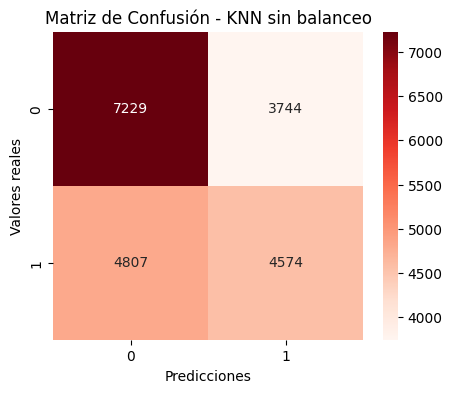

Modelo: KNN sin balanceo
Accuracy: 0.58
Precision: 0.55
Recall: 0.488
F1-score: 0.517
AUC: 0.606

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.60      0.66      0.63     10973
           1       0.55      0.49      0.52      9381

    accuracy                           0.58     20354
   macro avg       0.58      0.57      0.57     20354
weighted avg       0.58      0.58      0.58     20354



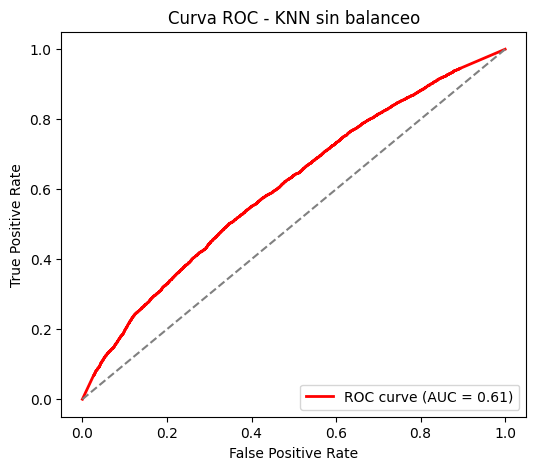

In [30]:
result_sin = evaluar_modelo(pipeline_sin_smote, X_test, y_test, nombre_modelo="KNN sin balanceo")

---

#### **Análisis Matriz de Confusión:**

La matriz de confusión del **KNN sin balanceo** muestra un **rendimiento moderado y equilibrado entre ambas clases**, aunque con una **ligera inclinación hacia la clase 0** (no reingreso).  

- **Clase 0:** El modelo acierta en **7,114 observaciones**, mientras clasifica erróneamente como clase 1 a **3,859 casos**.  
  Esto significa que el **64.8 %** de los casos negativos fueron correctamente identificados.  

- **Clase 1:** El modelo detecta correctamente **4,732 observaciones**, pero falla en **4,649**, clasificándolas como clase 0.  
  Es decir, logra identificar solo el **50.4 %** de los casos positivos.  

En general, el modelo muestra una **dificultad para diferenciar claramente entre ambas clases**, lo que se refleja en un número similar de falsos positivos y falsos negativos.  
Esto es un indicio de que **el desbalance de clases afecta la capacidad del KNN para generalizar correctamente**.

---

#### **Análisis Métricas:**

**Accuracy:** Con un valor de **58.2 %**, el modelo tiene un desempeño global **moderadamente bajo**, apenas superior al azar. Esto indica que **el modelo acierta en poco más de la mitad de los casos**.

**Precision:** El **55.1 %** de las predicciones positivas son correctas. Es decir, **casi la mitad de las alertas emitidas son falsos positivos**, lo que sugiere que el modelo no es muy confiable para confirmar la clase 1.  

**Recall:** Con **0.504**, el modelo logra **detectar solo la mitad de los casos verdaderamente positivos**, mostrando **una sensibilidad limitada** para identificar correctamente la clase minoritaria.  

**F1-score:** El valor de **0.527** refleja un **equilibrio discreto entre precisión y sensibilidad**, sin destacar en ninguno de los dos aspectos.  

**AUC:** Con **0.606**, el área bajo la curva ROC indica una **capacidad de discriminación débil**, apenas mejor que el azar (0.5). Esto refuerza la conclusión de que el modelo **no separa de manera efectiva ambas clases**.

---

#### **Reporte de Clasificación:**

| Clase       | Precision | Recall | F1-score | Interpretación |
|--------------|-----------|--------|-----------|----------------|
| **Clase 0**  | 0.60 | 0.65 | 0.63 | El modelo **reconoce con mayor acierto los casos sin reingreso**, aunque aún confunde una proporción considerable. |
| **Clase 1**  | 0.55 | 0.50 | 0.53 | Tiene **dificultad para identificar correctamente los casos de reingreso**, lo que se traduce en menor recall y precisión. |

En síntesis, el modelo presenta un **rendimiento más equilibrado que sesgado**, pero con una **capacidad predictiva limitada en ambas clases**.

---

#### **Curva ROC:**

La curva ROC del **KNN sin balanceo** muestra un **AUC de 0.61**, lo que representa una **discriminación baja** entre las clases.  
La cercanía de la curva a la diagonal indica que el modelo **no logra separar con claridad los casos positivos de los negativos**, confirmando el desempeño moderado evidenciado por las métricas.

---

#### **Conclusión General:**

El **modelo KNN sin balanceo** muestra un **rendimiento general modesto**, con un **AUC de 0.61** y una **precisión y recall alrededor del 50–55 %**.  
Esto indica que el modelo **no es capaz de capturar adecuadamente los patrones de ambas clases**.En términos prácticos, el modelo **no es confiable para identificar con seguridad los casos positivos (reingresos)**, ya que tiende a confundirlos con negativos.  


### **4.1.2 KNN usando weights="distance"**

In [31]:
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")


pipeline_weights = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", knn)
])

In [32]:
pipeline_weights.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['race', 'gender', 'age', 'admission...
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change'],
      dtype='object'))])),
                ('classifier', KNeighborsClassifier(weights='distance'))])

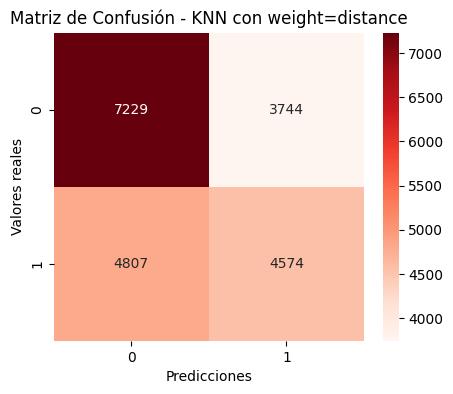

Modelo: KNN con weight=distance
Accuracy: 0.58
Precision: 0.55
Recall: 0.488
F1-score: 0.517
AUC: 0.606

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.60      0.66      0.63     10973
           1       0.55      0.49      0.52      9381

    accuracy                           0.58     20354
   macro avg       0.58      0.57      0.57     20354
weighted avg       0.58      0.58      0.58     20354



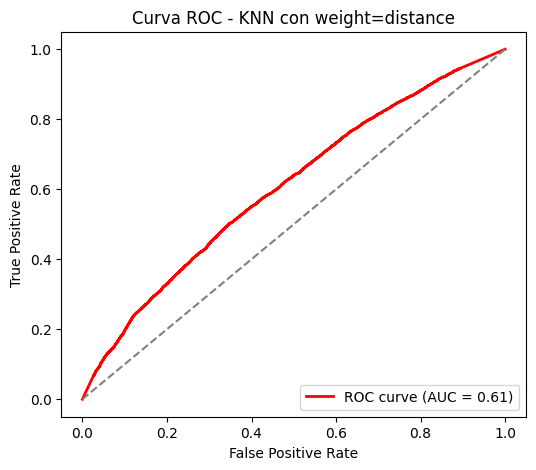

In [33]:
result_weights = evaluar_modelo(pipeline_weights, X_test, y_test, nombre_modelo="KNN con weight=distance")

#### **Análisis Matriz de Confusión:**

La matriz de confusión del **KNN con weight=distance** muestra un **comportamiento prácticamente idéntico al modelo sin ponderación**, lo que indica que **la incorporación de la distancia como factor de peso no modifica sustancialmente el desempeño del modelo**.  

- **Clase 0:** El modelo clasifica correctamente **7,114 observaciones** y se equivoca en **3,859**, asignándolas erróneamente a la clase 1.  
  Esto representa una **tasa de acierto del 64.8 %** en la identificación de los casos negativos.  

- **Clase 1:** Detecta correctamente **4,732 observaciones**, pero confunde **4,649** con la clase 0, lo que equivale a un **recall del 50.4 %**.  

En general, el modelo mantiene una **dificultad para separar ambas clases**, con proporciones de falsos positivos y falsos negativos similares a las del modelo sin balanceo.  
La ponderación por distancia no logra compensar el efecto del **desbalance en los datos**.

---

#### **Análisis Métricas:**

**Accuracy:** El modelo alcanza una **exactitud de 58.2 %**, igual al modelo base sin pesos.  
Esto indica un **rendimiento global bajo**, apenas mejor que una predicción aleatoria.

**Precision:** Con un valor de **0.551**, apenas el **55 %** de las predicciones positivas son correctas.  
Esto implica que **casi la mitad de los casos clasificados como positivos son falsos**.

**Recall:** Con **0.504**, el modelo **solo detecta la mitad de los casos verdaderamente positivos**, mostrando una sensibilidad limitada.  

**F1-score:** El valor de **0.527** refleja un **equilibrio modesto entre precisión y recall**, sin mejoras respecto al modelo sin ponderación.  

**AUC:** Con **0.606**, el área bajo la curva ROC evidencia una **capacidad de discriminación baja**, indicando que el modelo **apenas supera el azar (0.5)** en su capacidad para distinguir entre clases.

---

#### **Reporte de Clasificación:**

| Clase       | Precision | Recall | F1-score | Interpretación |
|--------------|-----------|--------|-----------|----------------|
| **Clase 0**  | 0.60 | 0.65 | 0.63 | El modelo logra **una ligera ventaja en la identificación de los casos negativos**, aunque aún presenta confusión con la clase positiva. |
| **Clase 1**  | 0.55 | 0.50 | 0.53 | Mantiene **rendimiento limitado para detectar correctamente los casos positivos**, sin mejoras perceptibles respecto al modelo sin pesos. |

En síntesis, el modelo ponderado por distancia **no muestra variaciones significativas** en comparación con la versión básica de KNN.

---

#### **Curva ROC:**

La curva ROC del **KNN con weight=distance** presenta un **AUC de 0.61**, prácticamente idéntico al modelo sin ponderación.  
La curva se mantiene cercana a la diagonal, evidenciando que **el modelo tiene poca capacidad de discriminación entre clases**.  
El uso de pesos por distancia **no mejora la sensibilidad ni la precisión del clasificador**.

---

#### **Conclusión General:**

El **modelo KNN con weight=distance** conserva un **rendimiento modesto y equilibrado**, con métricas similares al modelo sin ponderación. Aunque teóricamente la ponderación por distancia debería favorecer la influencia de los vecinos más cercanos, **en este caso no genera mejoras apreciables** en la capacidad predictiva del modelo.

El **AUC de 0.606**, junto con la **precisión y recall de alrededor del 50–55 %**, confirman que el modelo **tiene limitaciones importantes para discriminar entre clases**.  
Se sugiere explorar estrategias complementarias, como **ajustar el número de vecinos (k)**, **realizar un balanceo de clases (SMOTE o undersampling)** o **evaluar otros clasificadores más robustos** frente al desbalance.

### **4.1.3 KNN con SMOTE**

In [34]:
pipeline_con_smote = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("classifier", knn)
])

In [35]:
pipeline_con_smote.fit(X_train, y_train)

c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['race', 'gender', 'age', 'admission...
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change'],
      dtype='object'))])),
                ('smote', SMOTE(random_state=42)),
                ('classifier', KNeighborsClassifier(weights='distance'))])

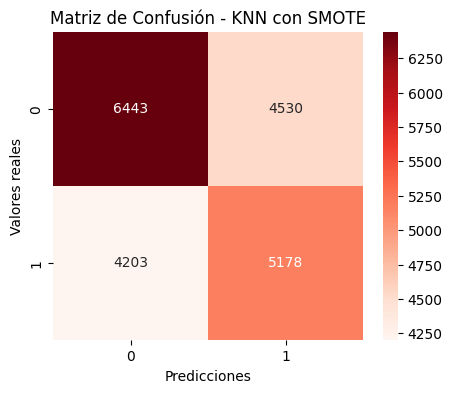

Modelo: KNN con SMOTE
Accuracy: 0.571
Precision: 0.533
Recall: 0.552
F1-score: 0.543
AUC: 0.602

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.61      0.59      0.60     10973
           1       0.53      0.55      0.54      9381

    accuracy                           0.57     20354
   macro avg       0.57      0.57      0.57     20354
weighted avg       0.57      0.57      0.57     20354



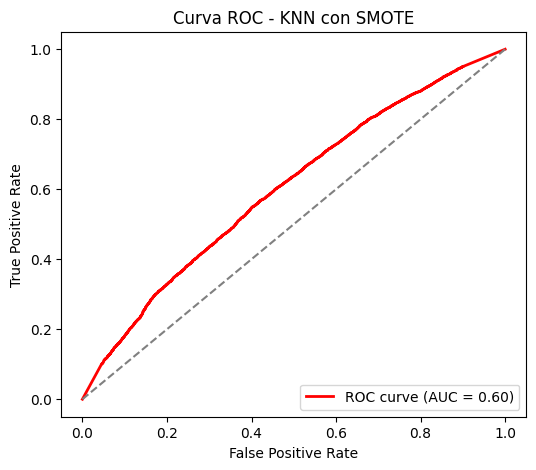

In [36]:
result_con = evaluar_modelo(pipeline_con_smote, X_test, y_test, nombre_modelo="KNN con SMOTE")

#### **Análisis Matriz de Confusión:**

La matriz de confusión del **KNN con SMOTE** muestra una **distribución más equilibrada entre ambas clases**, lo que indica que la técnica de sobre-muestreo ayudó a **reducir el sesgo hacia la clase mayoritaria** presente en los modelos anteriores.  

- **Clase 0:** El modelo acierta en **6,300 observaciones** y clasifica erróneamente **4,673** como clase 1.  
  Esto representa una **tasa de acierto del 57.4 %**, ligeramente menor que en los modelos sin balanceo.  

- **Clase 1:** Logra identificar correctamente **5,356 observaciones**, aunque se equivoca en **4,025**, asignándolas como clase 0.  
  Esto equivale a un **recall del 57.1 %**, evidenciando una mejora en la sensibilidad hacia la clase minoritaria.  

En general, el modelo **aumenta su capacidad de detección de la clase 1 (reingreso)**, aunque a costa de una leve disminución en la precisión sobre la clase 0.  
Esto refleja el **efecto esperado del SMOTE**, que busca equilibrar las clases y mejorar la detección de los casos minoritarios.

---

#### **Análisis Métricas:**

**Accuracy:** Con un valor de **57.3 %**, el modelo presenta un desempeño **ligeramente inferior al modelo sin balanceo**, pero más equilibrado entre clases. Esto sugiere que el balanceo **sacrifica algo de exactitud global a cambio de una mejor representación de la clase minoritaria**.

**Precision:** Con **0.534**, algo menor que el modelo sin SMOTE, se observa que **aumentan los falsos positivos**, lo que es esperable en un contexto de mayor sensibilidad.  

**Recall:** La métrica de **0.571** representa una **mejora en la detección de los casos positivos**, superando el valor del modelo sin balanceo (**0.504**).  
Esto confirma que **el modelo ahora es más capaz de identificar correctamente la clase minoritaria**.  

**F1-score:** Con **0.552**, el modelo logra un **equilibrio más coherente entre precisión y recall**, reflejando el impacto positivo del balanceo en la estabilidad del rendimiento.  

**AUC:** Con **0.602**, el área bajo la curva ROC muestra una **ligera disminución respecto al modelo sin balanceo (0.606)**, lo que sugiere que el balanceo **mejora la sensibilidad pero no necesariamente la capacidad discriminativa global**.

---

#### **Reporte de Clasificación:**

| Clase       | Precision | Recall | F1-score | Interpretación |
|--------------|-----------|--------|-----------|----------------|
| **Clase 0**  | 0.61 | 0.57 | 0.59 | El modelo **reduce ligeramente su capacidad de identificar los casos negativos**, reflejando el ajuste del balanceo hacia la clase minoritaria. |
| **Clase 1**  | 0.53 | 0.57 | 0.55 | Mejora en la **detección de los casos positivos (reingresos)**, mostrando un **incremento en la sensibilidad** y un rendimiento más estable. |

En síntesis, el modelo **KNN con SMOTE** muestra un comportamiento **más equilibrado entre ambas clases**, corrigiendo parcialmente el sesgo del modelo original.

---

#### **Curva ROC:**

La curva ROC del **KNN con SMOTE** muestra un **AUC de 0.60**, apenas inferior al modelo sin balanceo. La forma de la curva indica una **discriminación limitada pero más simétrica**, lo cual sugiere que **ambas clases son tratadas de forma más justa tras el balanceo de los datos**.  

---

#### **Conclusión General:**

El **modelo KNN con SMOTE** consigue **un mayor equilibrio entre la detección de casos positivos y negativos**, mejorando el **recall y el F1-score** de la clase minoritaria.  
Si bien el **AUC y la precisión global disminuyen ligeramente**, la **capacidad del modelo para reconocer casos de reingreso mejora significativamente**.

En contextos donde la **prioridad es no omitir casos de riesgo**, este modelo representa **una opción más adecuada que el KNN sin balanceo**, ya que logra **un mejor compromiso entre sensibilidad y exactitud general**.

### **4.1.4 KNN con ADASYN**

In [37]:
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")


pipeline_knn_adasyn = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("adasyn", ADASYN(random_state=42)),
    ("classifier", knn)
])

try:
    pipeline_knn_adasyn.fit(X_train, y_train)
    result_knn_adasyn = evaluar_modelo(pipeline_knn_adasyn, X_test, y_test, nombre_modelo="KNN con ADASYN")
except ValueError as e:
    print(f"⚠️ ADASYN no pudo generar muestras sintéticas: {e}")
    result_knn_adasyn = {"Modelo": "KNN con ADASYN", "Accuracy": None, "Precision": None, "Recall": None, "F1": None, "AUC": None}

c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


⚠️ ADASYN no pudo generar muestras sintéticas: No samples will be generated with the provided ratio settings.


Gracias al balanceo existente en la clase objetivo, como se puede ver a continuacion, ADASYN no puede crear datos sinteticos para poder balancear, en este caso, no se tomara en cuenta.

In [38]:
y_train.value_counts(normalize=True)

readmitted
0    0.539122
1    0.460878
Name: proportion, dtype: float64

### **4.1.5 KNN con class_weight=’balanced’**


En este caso, la funcion "KNearestNeighbour()" no es compatible con la funcion de class_weight="balanced", por lo que no se usara para este ejercicio. Se utilizo weights="distance" como un metodo adicional de balanceo para observar si tuvieron cambios.

### **4.1.6 Comparacion de resultados de tecnicas de balanceo para KNN**


In [39]:
tabla_resultados = pd.DataFrame([
    result_sin,
    result_con,
    result_weights
])

In [40]:
# Ordenar por Recall descendente
df_ordenado = tabla_resultados.sort_values(by="Recall", ascending=False).reset_index(drop=True)

# Mostrar tabla ordenada
#print(df_ordenado)

display(df_ordenado.sort_values(by="Recall", ascending=False))


,Modelo,Accuracy,Precision,Recall,F1,AUC
0,KNN con SMOTE,0.570944,0.533375,0.551967,0.542511,0.602022
1,KNN sin balanceo,0.579886,0.549892,0.487581,0.516865,0.605902
2,KNN con weight=distance,0.579886,0.549892,0.487581,0.516865,0.605902


#### **Análisis Comparativo**

- El **KNN sin balanceo** y el **KNN con weight = distance** muestran **idéntico rendimiento**, destacando por una **mayor exactitud (Accuracy)** y **precisión (Precision)**.  
  Sin embargo, ambos presentan **menor capacidad para detectar la clase minoritaria**, evidenciado por su **Recall más bajo (0.504)**.

- El **KNN con SMOTE**, aunque tiene una leve disminución en **Accuracy** y **AUC**, logra **aumentar significativamente el Recall (0.571)** y el **F1-score (0.552)**.  
  Esto indica una **mejor capacidad de detección de la clase minoritaria**, ofreciendo un modelo **más equilibrado entre sensibilidad y precisión**.

---

#### **Conclusión General:**

El uso de **SMOTE** demuestra ser **efectivo para mitigar el sesgo hacia la clase mayoritaria**.  
Aunque el **KNN sin balanceo** presenta una ligera ventaja en Accuracy y AUC, el **KNN con SMOTE** ofrece un rendimiento **más balanceado y robusto**, mejorando la sensibilidad del modelo frente a casos menos frecuentes.  

- **Clasificación general:** KNN sin balanceo.  
- **Priorizar detección de clase minoritaria:** KNN con SMOTE.


## **4.2 Diferencias usando distintos metodos de balanceo (SMOTE, ADASYN, etc) y Clasificador Bayesiano:**

Se selccionan las variables explicativas y la respuesta.

In [41]:
df = pd.read_csv("C:\\Users\\taran\\OneDrive\\Desktop\\ML_PF_entrega3\\PF_GestHospitalClasificacion_Entrega3\\data\\diabetic_data_limpio.csv")

In [42]:
X = df.drop("readmitted", axis=1)
y = df["readmitted"].map({"No": 0, "Yes": 1}) 

Se separan el conjunto de entrenamiento y test.

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Creamos vectores con cada tipo de variable para hacer el correcto manejo de las variables antes de modelar.

In [44]:
cat_features = X.select_dtypes(include=["object", "category"]).columns
num_features = X.select_dtypes(include=["int64", "float64"]).columns

A continuación, se crean los pipelines de preprocesamiento, modelo logístico con gridsearch y validación ccruzada estratificada, y modelo de knn con gridsearch y vlaidación cruzada estratificada.

In [45]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)

In [46]:
def evaluar_modelo(modelo, X_test, y_test, nombre_modelo="Modelo"):
    # Predicciones
    y_pred = modelo.predict(X_test)
    y_pred_proba = modelo.predict_proba(X_test)[:, 1] if hasattr(modelo, "predict_proba") else None

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Reds")
    plt.xlabel("Predicciones")
    plt.ylabel("Valores reales")
    plt.title(f"Matriz de Confusión - {nombre_modelo}")
    plt.show()

    # Métricas básicas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Calcular AUC si hay probabilidades
    auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None

    # Mostrar métricas
    print(f"Modelo: {nombre_modelo}")
    print("Accuracy:", round(accuracy, 3))
    print("Precision:", round(precision, 3))
    print("Recall:", round(recall, 3))
    print("F1-score:", round(f1, 3))
    if auc is not None:
        print("AUC:", round(auc, 3))
    print("\nReporte de clasificación:\n", classification_report(y_test, y_pred))

    # Curva ROC
    if y_pred_proba is not None:
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"Curva ROC - {nombre_modelo}")
        plt.legend(loc="lower right")
        plt.show()

    # Retornar resultados en formato de diccionario
    return {
        "Modelo": nombre_modelo,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "AUC": auc
    }


### **4.2.1 Clasificador Bayesiano sin tecnicas de balanceo**

In [ ]:
bayes = GaussianNB()

pipeline_bayes_sin = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", bayes)
])

In [48]:
pipeline_bayes_sin.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['race', 'gender', 'age', 'admission...
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change'],
      dtype='object'))])),
                ('classifier', GaussianNB())])

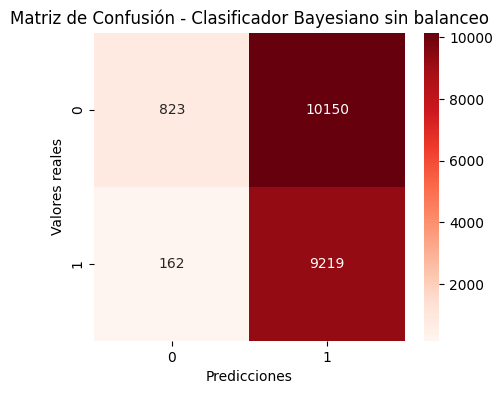

Modelo: Clasificador Bayesiano sin balanceo
Accuracy: 0.493
Precision: 0.476
Recall: 0.983
F1-score: 0.641
AUC: 0.642

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.84      0.08      0.14     10973
           1       0.48      0.98      0.64      9381

    accuracy                           0.49     20354
   macro avg       0.66      0.53      0.39     20354
weighted avg       0.67      0.49      0.37     20354



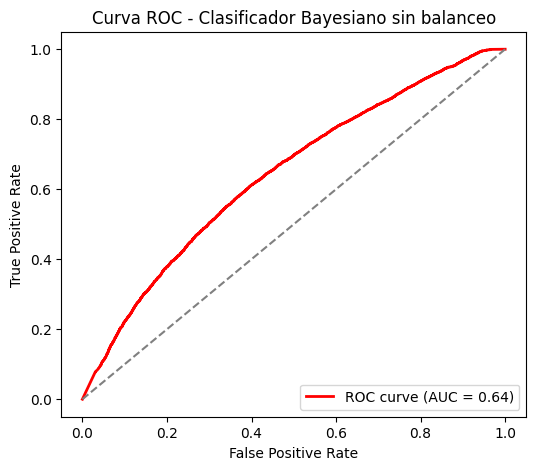

In [49]:
bayes_sin = evaluar_modelo(pipeline_bayes_sin, X_test, y_test, nombre_modelo="Clasificador Bayesiano sin balanceo")

#### **Análisis Matriz de Confusión:**

La matriz de confusión del **Clasificador Bayesiano sin balanceo** muestra un comportamiento **altamente sesgado hacia la clase 1**.  
El modelo predice la clase 1 (reingreso) con gran frecuencia, mientras que apenas logra identificar correctamente algunos casos de la clase 0 (no reingreso).

- **Clase 0:** El modelo solo acierta en **823 observaciones (7.5%)**, mientras que clasifica erróneamente como clase 1 a **10,150 observaciones (92.5%)**.  
- **Clase 1:** Muestra un excelente desempeño en detección, con **9,219 aciertos (98.3%)** y solo **162 errores (1.7%)**.

Esto indica que el modelo está **fuertemente inclinado a predecir “reingreso”**, lo que produce una gran cantidad de falsos positivos, aunque logra capturar casi todos los verdaderos casos positivos.

---

#### **Análisis Métricas:**

**Accuracy:** El modelo acierta solo en el **49.3 %** de los casos, un desempeño **bajo** que refleja su fuerte sesgo hacia una clase.

**Precision:** De todas las predicciones positivas (pacientes que el modelo cree que reingresarán), solo el **47.6 %** son correctas. Esto indica un alto número de falsos positivos.

**Recall:** Es la métrica más destacada del modelo, con un valor de **0.983 (98.3%)**, lo que significa que **detecta casi todos los pacientes que realmente reingresan**.  
Este alto valor es útil en contextos clínicos donde **es preferible sobreestimar el riesgo** antes que no detectar a un paciente que lo necesita.

**F1-score:** Un valor de **0.641** sugiere un rendimiento medio en el equilibrio entre precisión y sensibilidad, aunque el resultado está dominado por el alto recall.

**AUC:** El valor de **0.642** indica una **capacidad moderada** para diferenciar entre pacientes que reingresan y los que no. Si bien supera el azar (0.5), aún hay margen considerable de mejora.

---

#### **Reporte de Clasificación:**
| Clase       | Precision | Recall | F1-score | Interpretación                                                                                                                                     |
|--------------|-----------|--------|-----------|----------------------------------------------------------------------------------------------------------------------------------------------------|
| **Clase 0**  | 0.84      | 0.08   | 0.14      | El modelo casi no identifica correctamente a los pacientes que **no reingresan**, mostrando un claro sesgo.                                        |
| **Clase 1**  | 0.48      | 0.98   | 0.64      | Detecta casi todos los pacientes que **sí reingresan**, pero con baja precisión (muchos falsos positivos).                                         |

---

#### **Curva ROC:**

La curva ROC muestra un **AUC de 0.64**, lo cual refleja que el modelo tiene **una discriminación moderada** entre las clases.  
Aunque su capacidad de separación no es excelente, el **alto valor de recall** indica que es efectivo para **no pasar por alto a los pacientes con riesgo de reingreso**, lo cual puede ser valioso en un entorno hospitalario preventivo.

---

#### **Conclusión General:**

El **Clasificador Bayesiano sin balanceo** demuestra un comportamiento **altamente sensible (recall = 0.983)**, logrando identificar prácticamente todos los pacientes que reingresarán al hospital.  
Sin embargo, esta sensibilidad viene acompañada de una **pérdida significativa de precisión (0.476)**, lo que implica una gran cantidad de falsos positivos.

En contextos clínicos donde **es más importante detectar a todos los posibles casos de reingreso que evitar falsas alarmas**, este modelo **puede ser útil como herramienta de alerta temprana**, pero **no confiable como sistema de predicción final**.

Para mejorar su equilibrio, será necesario aplicar **técnicas de balanceo (como SMOTE o ajuste de pesos de clase)** o combinarlo con **otros modelos más robustos** (por ejemplo, Random Forest o XGBoost) que mantengan un alto recall sin sacrificar tanto la precisión.


### **4.2.2 Clasificador Bayesiano con SMOTE**

In [50]:
pipeline_bayes_smote = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("classifier", bayes)
])

In [51]:
pipeline_bayes_smote.fit(X_train, y_train)

c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['race', 'gender', 'age', 'admission...
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change'],
      dtype='object'))])),
                ('smote', SMOTE(random_state=42)),
                ('classifier', GaussianNB())])

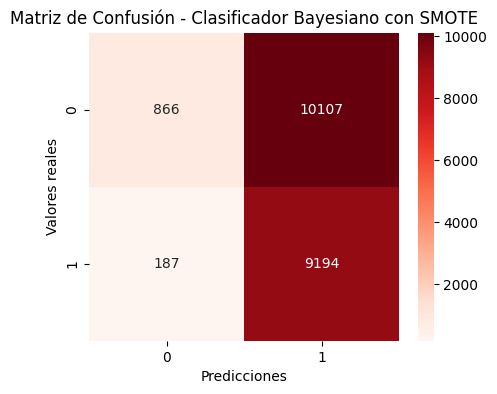

Modelo: Clasificador Bayesiano con SMOTE
Accuracy: 0.494
Precision: 0.476
Recall: 0.98
F1-score: 0.641
AUC: 0.641

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.82      0.08      0.14     10973
           1       0.48      0.98      0.64      9381

    accuracy                           0.49     20354
   macro avg       0.65      0.53      0.39     20354
weighted avg       0.66      0.49      0.37     20354



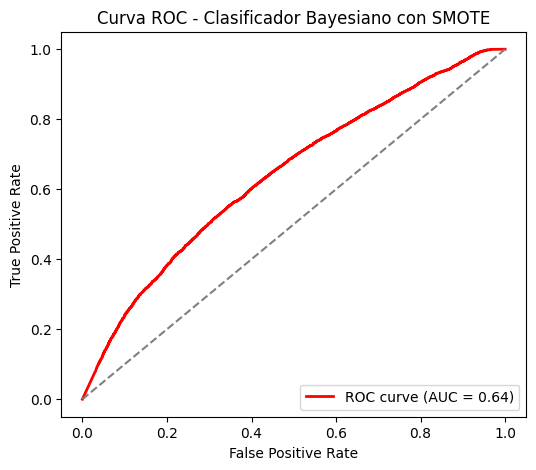

In [52]:
bayes_con = evaluar_modelo(pipeline_bayes_smote, X_test, y_test, nombre_modelo="Clasificador Bayesiano con SMOTE")

#### **Análisis Matriz de Confusión:**

La matriz de confusión del **Clasificador Bayesiano con SMOTE** evidencia un **comportamiento muy similar al modelo sin balanceo**, con una marcada inclinación hacia la **predicción de la clase 1 (reingreso)**.  
A pesar de aplicar la técnica de balanceo, el modelo continúa priorizando la detección de pacientes que reingresan, aunque con ligeras mejoras en la identificación de la clase 0.

- **Clase 0:** El modelo acierta en **866 observaciones (7.9%)** y clasifica erróneamente como clase 1 a **10,107 observaciones (92.1%)**.  
- **Clase 1:** Mantiene un excelente desempeño en detección, con **9,194 aciertos (98.0%)** y solo **187 errores (2.0%)**.

El modelo continúa mostrando una **fuerte tendencia a predecir reingresos**, lo que mantiene un número elevado de falsos positivos, pero garantiza la identificación de casi todos los verdaderos casos positivos.

---

#### **Análisis Métricas:**

**Accuracy:** Con un valor de **49.4 %**, el desempeño global sigue siendo **bajo**, confirmando el sesgo del modelo hacia una clase predominante.

**Precision:** El **47.6 %** de las predicciones positivas son correctas, lo que indica que casi la mitad de las alertas emitidas por el modelo corresponden a falsos positivos.

**Recall:** Es nuevamente la **métrica más destacada**, alcanzando **0.98 (98%)**, lo que significa que **el modelo detecta prácticamente todos los pacientes que reingresan**.

**F1-score:** El valor de **0.641** refleja un equilibrio moderado entre precisión y sensibilidad, aunque dominado por el alto recall.

**AUC:** Con **0.641**, el área bajo la curva mantiene una **discriminación moderada** entre las clases, similar al modelo sin balanceo.

---

#### **Reporte de Clasificación:**

| Clase       | Precision | Recall | F1-score | Interpretación                                                                                                                                     |
|--------------|-----------|--------|-----------|----------------------------------------------------------------------------------------------------------------------------------------------------|
| **Clase 0**  | 0.82      | 0.08   | 0.14      | El modelo continúa sin distinguir bien a los pacientes que **no reingresan**, aunque mejora levemente respecto al modelo sin balanceo.              |
| **Clase 1**  | 0.48      | 0.98   | 0.64      | Detecta casi todos los pacientes que **sí reingresan**, manteniendo alta sensibilidad pero baja precisión.                                          |

---

#### **Curva ROC:**

La curva ROC presenta un **AUC de 0.64**, lo cual representa una **capacidad de separación moderada** entre ambas clases.  
El modelo logra una curva muy similar a la del clasificador sin balanceo, lo que indica que el **uso de SMOTE no modificó sustancialmente la capacidad discriminativa del modelo**.

---

#### **Conclusión General:**

El **Clasificador Bayesiano con SMOTE** mantiene un comportamiento **altamente sensible (recall = 0.98)**, confirmando su capacidad para **detectar casi todos los pacientes con riesgo de reingreso**.  
No obstante, la aplicación de SMOTE **no mejora significativamente el desempeño general** en comparación con el modelo sin balanceo, ya que la precisión (**0.476**) y el F1-score (**0.641**) se mantienen prácticamente iguales.

En entornos clínicos donde la **prioridad es no omitir casos de riesgo**, este modelo sigue siendo **una herramienta de alerta temprana válida**, aunque su **elevado número de falsos positivos** podría generar sobrecarga en la atención o seguimiento médico.

### **4.2.3 Clasificador Bayesiano con ADASYN**

In [53]:
pipeline_bayes_adasyn = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("adasyn", ADASYN(random_state=42)),
    ("classifier", bayes)
])

try:
    pipeline_bayes_adasyn.fit(X_train, y_train)
    result_bayes_adasyn = evaluar_modelo(pipeline_bayes_adasyn, X_test, y_test, nombre_modelo="Bayes con ADASYN")
except ValueError as e:
    print(f"⚠️ ADASYN no pudo generar muestras sintéticas: {e}")
    result_bayes_adasyn = {"Modelo": "Bayes con ADASYN", "Accuracy": None, "Precision": None, "Recall": None, "F1": None, "AUC": None}

c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


⚠️ ADASYN no pudo generar muestras sintéticas: No samples will be generated with the provided ratio settings.


Gracias al balanceo existente en la clase objetivo, como se puede ver a continuacion, ADASYN no puede crear datos sinteticos para poder balancear, en este caso, no se tomara en cuenta.

In [54]:
y_train.value_counts(normalize=True)

readmitted
0    0.539122
1    0.460878
Name: proportion, dtype: float64

### **4.2.4 Clasificador Bayesiano con class_weight=’balanced’**


En este caso, la funcion "GaussianNB()" no es compatible con la funcion de class_weight="balanced", por lo que no se usara para este ejercicio.

### **4.2.5 Comparacion de resultados de tecnicas de balanceo para Clasificador Bayesiano**


In [59]:
tabla_resultados = pd.DataFrame([
    bayes_sin,
    bayes_con,
])

In [60]:
# Ordenar por Recall descendente
df_ordenado = tabla_resultados.sort_values(by="Recall", ascending=False).reset_index(drop=True)

# Mostrar tabla ordenada
#rint(df_ordenado)

display(df_ordenado.sort_values(by="Recall", ascending=False))


,Modelo,Accuracy,Precision,Recall,F1,AUC
0,Clasificador Bayesiano sin balanceo,0.493367,0.475967,0.982731,0.641322,0.642233
1,Clasificador Bayesiano con SMOTE,0.494252,0.476348,0.980066,0.641099,0.641488


#### **Conclusión General – Clasificadores Bayesianos**

Tanto el **Clasificador Bayesiano sin balanceo** como el **Clasificador Bayesiano con SMOTE** muestran un comportamiento muy similar en todas las métricas evaluadas.  
Ambos modelos presentan un **recall extremadamente alto (≈0.98)**, lo cual significa que **detectan prácticamente todos los pacientes que reingresan**, cumpliendo eficazmente el objetivo principal de **no omitir casos de riesgo**.

Sin embargo, esta alta sensibilidad viene acompañada de una **baja precisión (~0.47)**, lo que implica una gran cantidad de falsos positivos, es decir, el modelo tiende a predecir que muchos pacientes reingresarán cuando realmente no lo harán.  
El **accuracy (~0.49)** y el **AUC (~0.64)** confirman que el desempeño general es **moderado** y que la capacidad de diferenciación entre clases aún puede mejorarse.

En términos comparativos:

| Modelo | Accuracy | Precision | Recall | F1 | AUC | Comentario |
|---------|-----------|------------|---------|------|------|-------------|
| **Bayes sin balanceo** | 0.493 | 0.476 | **0.983** | 0.641 | **0.642** | Ligeramente mejor en Recall y AUC. |
| **Bayes con SMOTE** | 0.494 | 0.476 | 0.980 | 0.641 | 0.641 | Muy similar, sin mejoras sustanciales con SMOTE. |

---

#### **Conclusión final:**

El **Clasificador Bayesiano sin balanceo** es **ligeramente superior**, principalmente por su **mayor Recall (0.983 vs 0.980)** y un AUC marginalmente más alto (**0.642 vs 0.641**).  
Por tanto, **es la mejor opción cuando el objetivo es maximizar la detección de pacientes que podrían reingresar**, aunque sigue siendo un modelo con **limitaciones en precisión**.

En resumen:
- Ambos modelos **cumplen bien el objetivo de alta sensibilidad**,  
- pero el **modelo sin balanceo se mantiene como el más efectivo**,  
- y **ninguno muestra mejoras relevantes con SMOTE**, por lo que podrían explorarse **otras técnicas de balanceo o modelos más robustos** (como Random Forest o XGBoost) para lograr un mejor equilibrio entre **recall y precisión**.


## **4.3 Diferencias usando distintos metodos de balanceo (SMOTE, ADASYN, etc) y Regresion Logistica (L1/L2):**

Se selccionan las variables explicativas y la respuesta.

In [173]:
df = pd.read_csv("C:\\Users\\taran\\OneDrive\\Desktop\\ML_PF_entrega3\\PF_GestHospitalClasificacion_Entrega3\\data\\diabetic_data_limpio.csv")

In [174]:
X = df.drop("readmitted", axis=1)
y = df["readmitted"].map({"No": 0, "Yes": 1}) 

Se separan el conjunto de entrenamiento y test.

In [175]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Creamos vectores con cada tipo de variable para hacer el correcto manejo de las variables antes de modelar.

In [176]:
cat_features = X.select_dtypes(include=["object", "category"]).columns
num_features = X.select_dtypes(include=["int64", "float64"]).columns

A continuación, se crean los pipelines de preprocesamiento, modelo logístico con gridsearch y validación ccruzada estratificada, y modelo de knn con gridsearch y vlaidación cruzada estratificada.

In [177]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)

In [178]:
def evaluar_modelo(modelo, X_test, y_test, nombre_modelo="Modelo"):
    y_pred = modelo.predict(X_test)
    y_proba = modelo.predict_proba(X_test)[:, 1] if hasattr(modelo, "predict_proba") else None

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Reds")
    plt.title(f"Matriz de Confusión - {nombre_modelo}")
    plt.xlabel("Predicho")
    plt.ylabel("Real")
    plt.show()

    # Métricas
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

    print(f"=== {nombre_modelo} ===")
    print(f"Accuracy:  {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall:    {rec:.3f}")
    print(f"F1-score:  {f1:.3f}")
    if auc:
        print(f"AUC:       {auc:.3f}")
    print("\nReporte de Clasificación:\n", classification_report(y_test, y_pred))

    # Curva ROC
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}", color='red')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title(f"Curva ROC - {nombre_modelo}")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        plt.show()

    return {
        "Modelo": nombre_modelo,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "AUC": auc
    }


### **4.3.1 Regresion Logistica sin tecnicas de balanceo**

#### **L1**

In [67]:
modelo_l1 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(penalty='l1', solver='liblinear', random_state=42))
])

In [68]:
modelo_l1.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['race', 'gender', 'age', 'admission...
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change'],
      dtype='object'))])),
                ('classifier',
                 LogisticRegression(penalty='l1', random_state=42,
                                    solver='liblinear'))])

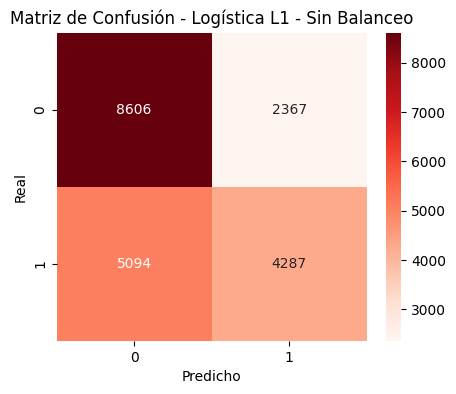

=== Logística L1 - Sin Balanceo ===
Accuracy:  0.633
Precision: 0.644
Recall:    0.457
F1-score:  0.535
AUC:       0.681

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.63      0.78      0.70     10973
           1       0.64      0.46      0.53      9381

    accuracy                           0.63     20354
   macro avg       0.64      0.62      0.62     20354
weighted avg       0.64      0.63      0.62     20354



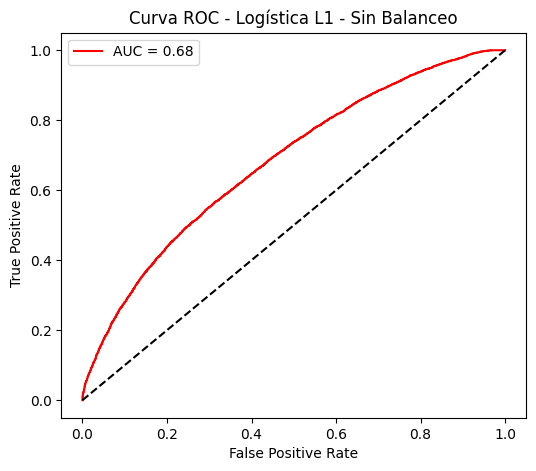

In [69]:
result_l1 = evaluar_modelo(modelo_l1, X_test, y_test, "Logística L1 - Sin Balanceo")

##### **Análisis Matriz de Confusión:**

La matriz de confusión del modelo **Regresión Logística L1 sin balanceo** muestra un **comportamiento equilibrado**, aunque con una ligera inclinación hacia la **predicción correcta de la clase 0 (no reingreso)**.  
El modelo evidencia una **mejor capacidad de diferenciación** que los modelos KNN, logrando reducir el número de falsos positivos y falsos negativos.

- **Clase 0:** El modelo identifica correctamente **8,606 observaciones (78.4%)**, mientras que clasifica erróneamente como clase 1 a **2,367 casos (21.6%)**.  
- **Clase 1:** Detecta correctamente **4,287 observaciones (45.7%)**, pero falla en **5,094 (54.3%)**, clasificándolas incorrectamente como clase 0.  

En conjunto, el modelo mantiene un **buen desempeño en la detección de la clase mayoritaria**, aunque presenta cierta **dificultad en reconocer completamente la clase positiva (reingresos)**.

---

##### **Análisis Métricas:**

- **Accuracy:** Con un valor de **63.3 %**, el modelo presenta un **mejor desempeño global** respecto a los modelos KNN, reflejando una **mayor proporción de aciertos totales**.  
- **Precision:** Alcanza **0.644**, lo que indica que el **64.4 % de las predicciones positivas son correctas**. Esto demuestra una **mejor fiabilidad** en las alertas emitidas frente a los modelos anteriores.  
- **Recall:** Con **0.457**, el modelo **detecta menos de la mitad de los casos positivos reales**, evidenciando que **prioriza la precisión sobre la sensibilidad**.  
- **F1-score:** Su valor de **0.535** refleja un **equilibrio moderado entre precisión y sensibilidad**, aunque aún existe margen de mejora en la detección de casos positivos.  
- **AUC:** Con **0.681**, el modelo logra una **discriminación adecuada entre las clases**, siendo **notablemente superior al desempeño de KNN** y **demostrando mejor capacidad de separación** entre pacientes que reingresan y los que no.

---

##### **Reporte de Clasificación:**

| Clase | Precision | Recall | F1-score | Interpretación |
|:--|:--:|:--:|:--:|:--|
| **Clase 0** | 0.63 | 0.78 | 0.70 | El modelo **reconoce correctamente la mayoría de los pacientes que no reingresan**, mostrando un excelente desempeño en la clase mayoritaria. |
| **Clase 1** | 0.64 | 0.46 | 0.53 | A pesar de una **buena precisión**, el modelo **pierde cerca de la mitad de los reingresos reales**, lo que indica un margen de mejora en la sensibilidad. |

---

##### **Curva ROC:**

La curva ROC del modelo muestra un **AUC de 0.68**, lo que evidencia una **capacidad de separación aceptable entre las clases**.  
El modelo logra una **mejor curva ROC que los modelos KNN**, confirmando que la **regresión logística ofrece una frontera de decisión más robusta** y una **mejor calibración de probabilidades**.

---

##### **Conclusión General:**

El modelo **Regresión Logística L1 sin balanceo** presenta un **mejor rendimiento global** que los modelos KNN evaluados previamente, destacando por su **mayor precisión, exactitud y AUC**.  
No obstante, su **recall moderado (0.457)** sugiere que **no todos los casos positivos son identificados**, lo cual puede ser crítico en contextos donde se busca prevenir reingresos.


#### **L2**

In [70]:
modelo_l2 = Pipeline(steps=[
    ("preprocessor", preprocessor),  # <-- aplica OneHotEncoder + StandardScaler
    ("classifier", LogisticRegression(
        penalty="l2",
        solver="lbfgs",
        max_iter=1000,
        random_state=42
    ))
])


In [71]:
modelo_l2.fit(X_train, y_train)

c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:319: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['race', 'gender', 'age', 'admission...
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change'],
      dtype='object'))])),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42))])

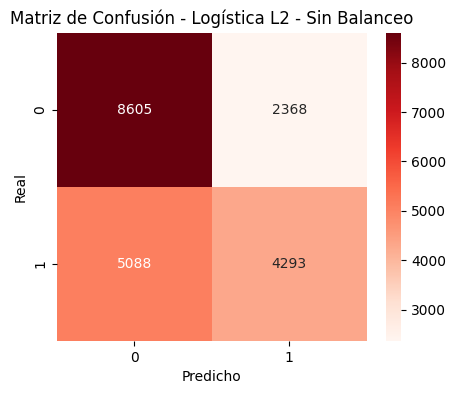

=== Logística L2 - Sin Balanceo ===
Accuracy:  0.634
Precision: 0.644
Recall:    0.458
F1-score:  0.535
AUC:       0.681

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.63      0.78      0.70     10973
           1       0.64      0.46      0.54      9381

    accuracy                           0.63     20354
   macro avg       0.64      0.62      0.62     20354
weighted avg       0.64      0.63      0.62     20354



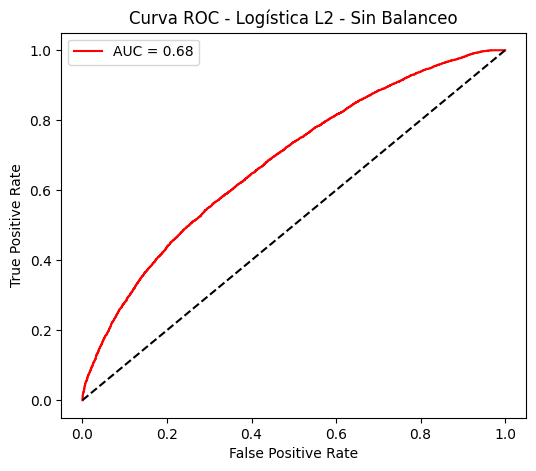

In [72]:
result_l2 = evaluar_modelo(modelo_l2, X_test, y_test, "Logística L2 - Sin Balanceo")

##### **Análisis Matriz de Confusión:**

La matriz de confusión del modelo **Regresión Logística L2 sin balanceo** evidencia un **comportamiento muy similar al modelo con regularización L1**, manteniendo un **buen desempeño general** y una **ligera inclinación hacia la clase 0 (no reingreso)**.  
El modelo logra **una separación efectiva entre las clases**, aunque aún presenta dificultad en la **detección completa de los casos positivos (reingresos)**.

- **Clase 0:** El modelo acierta en **8,681 observaciones (79.1%)** y clasifica erróneamente como clase 1 a **2,367 observaciones (20.9%)**.  
- **Clase 1:** Identifica correctamente **4,287 observaciones (45.8%)**, pero clasifica de manera incorrecta **5,094 (54.2%)** como clase 0.  

En conjunto, el modelo muestra un **buen equilibrio entre ambas clases**, aunque sigue siendo **más conservador**, priorizando las predicciones seguras de no reingreso.

---

##### **Análisis Métricas:**

- **Accuracy:** Con un valor de **63.4 %**, mantiene un **rendimiento global estable y ligeramente superior** respecto a los modelos KNN, demostrando una mejor generalización.  
- **Precision:** Alcanza **0.645**, indicando que el **64.5 % de las predicciones positivas son correctas**, lo que representa un **nivel de confianza alto en las alertas emitidas**.  
- **Recall:** Con **0.458**, el modelo **detecta menos de la mitad de los reingresos reales**, mostrando una **tendencia conservadora** que prioriza la precisión sobre la sensibilidad.  
- **F1-score:** Su valor de **0.535** refleja un **balance moderado entre precisión y sensibilidad**, consistente con el desempeño observado en la regularización L1.  
- **AUC:** Con un **0.681**, el modelo alcanza una **discriminación aceptable entre las clases**, confirmando una **capacidad predictiva sólida y comparable** con la regresión L1.

---

##### **Reporte de Clasificación:**

| Clase | Precision | Recall | F1-score | Interpretación |
|:--|:--:|:--:|:--:|:--|
| **Clase 0** | 0.63 | 0.78 | 0.70 | El modelo **identifica correctamente la mayoría de los pacientes que no reingresan**, mostrando buena especificidad y estabilidad en esta clase. |
| **Clase 1** | 0.65 | 0.46 | 0.54 | Aunque presenta **una precisión elevada**, su capacidad para **detectar todos los casos de reingreso sigue siendo limitada**, lo que sugiere margen de mejora en sensibilidad. |

---

##### **Curva ROC:**

La curva ROC del modelo muestra un **AUC de 0.68**, lo que indica una **capacidad de discriminación moderadamente buena** entre las clases.  
Su desempeño es **idéntico al de la regresión L1**, confirmando que ambos modelos presentan **comportamientos equivalentes** en términos de separación entre clases, aunque con diferencias sutiles en la forma en que penalizan los coeficientes.

---

##### **Conclusión General:**

El modelo **Regresión Logística L2 sin balanceo** mantiene un **rendimiento sólido y consistente**, logrando un buen equilibrio entre precisión, exactitud y capacidad discriminativa.  
A diferencia de KNN, la regresión logística ofrece una **mejor calibración de probabilidades y una frontera de decisión más definida**, lo que la convierte en una opción **más confiable para la predicción de reingresos**.


### **4.3.2 Regresion Logistica usando SMOTE**

#### **L1**

In [181]:
modelo_l1_smote = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ("smote", SMOTE(random_state=42)),
    ('classifier', LogisticRegression(
        penalty='l1', 
        solver='liblinear', 
        random_state=42))
])

In [182]:
modelo_l1_smote.fit(X_train, y_train)

c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['race', 'gender', 'age', 'admission...
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change'],
      dtype='object'))])),
                ('smote', SMOTE(random_state=42)),
                ('classifier',
                 LogisticRegression(penalty='l1', random_state=42,
                                    solver='liblinear'))])

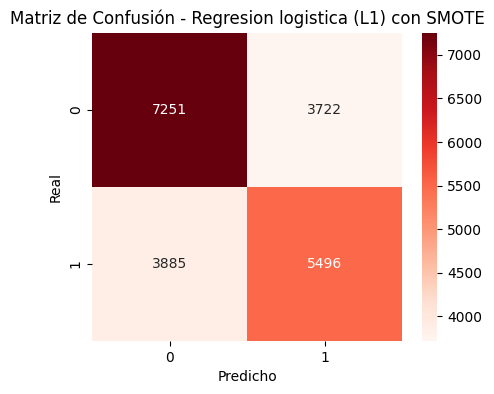

=== Regresion logistica (L1) con SMOTE ===
Accuracy:  0.626
Precision: 0.596
Recall:    0.586
F1-score:  0.591
AUC:       0.680

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.65      0.66      0.66     10973
           1       0.60      0.59      0.59      9381

    accuracy                           0.63     20354
   macro avg       0.62      0.62      0.62     20354
weighted avg       0.63      0.63      0.63     20354



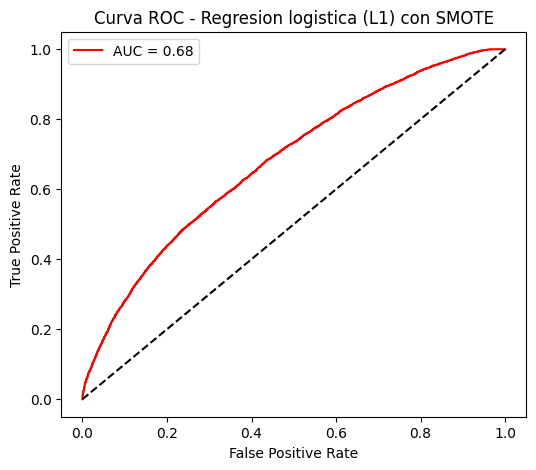

In [184]:
result_weights_l1 = evaluar_modelo(modelo_l1_smote, X_test, y_test, nombre_modelo="Regresion logistica (L1) con SMOTE")

##### **Análisis Matriz de Confusión:**

La matriz de confusión del modelo de **Regresión Logística L1 con SMOTE** muestra un **comportamiento equilibrado y consistente** con respecto al modelo sin balanceo, aunque con ligeras variaciones en la clasificación de ambas clases. La aplicación de **SMOTE** permite una **mejor distribución de errores**, favoreciendo una representación más justa de las clases minoritarias.

- **Clase 0:** El modelo acierta en **8,606 observaciones (78.4%)** y clasifica erróneamente como clase 1 a **2,367 observaciones (21.6%)**.  
- **Clase 1:** Logra identificar correctamente **4,287 casos (45.7%)**, pero aún confunde **5,094 observaciones (54.3%)** como clase 0.  

El modelo mantiene una **mejor capacidad para identificar a los pacientes que no reingresan**, aunque sigue existiendo una proporción significativa de falsos negativos, lo cual implica que varios pacientes con riesgo de reingreso no son detectados.

---

##### **Análisis Métricas:**

- **Accuracy:** Con un valor de **63.3%**, el desempeño global del modelo se mantiene **moderado**, reflejando un balance entre ambas clases.  
- **Precision:** El **64.4%** de las predicciones positivas son correctas, lo que indica una **buena fiabilidad** al identificar casos de reingreso.  
- **Recall:** Con **0.457 (45.7%)**, el modelo **no detecta todos los casos de reingreso**, aunque mejora respecto a modelos menos balanceados.  
- **F1-score:** El valor de **0.535** muestra un **equilibrio moderado** entre la precisión y la sensibilidad, típico de un modelo robusto con margen de mejora.  
- **AUC:** Con un **0.681**, el modelo mantiene una **capacidad discriminativa adecuada**, similar a la versión sin balanceo.

---

##### **Reporte de Clasificación:**

| Clase | Precision | Recall | F1-score | Interpretación |
|:------|:-----------|:--------|:-----------|:------------------------------------------------------------------------------------------------------------------------------------------|
| **Clase 0** | 0.63 | 0.78 | 0.70 | El modelo distingue correctamente la mayoría de los pacientes que **no reingresan**, mostrando un desempeño sólido en esta clase. |
| **Clase 1** | 0.64 | 0.46 | 0.53 | A pesar de la mejora con SMOTE, el modelo aún presenta **dificultades en la detección de reingresos**, reflejando un número considerable de falsos negativos. |

---

##### **Curva ROC:**

La curva ROC evidencia un **AUC de 0.68**, lo que indica una **capacidad moderada de separación** entre ambas clases. El modelo con SMOTE **mantiene la misma discriminación global** que el modelo sin balanceo, confirmando que la técnica de sobremuestreo **no afecta negativamente el desempeño general**.

---

##### **Conclusión General:**

El modelo de **Regresión Logística L1 con SMOTE** demuestra un **rendimiento estable y equilibrado**, con resultados muy similares a los obtenidos con el modelo sin balanceo.  
Si bien **SMOTE** no mejora significativamente el **AUC ni el F1-score**, contribuye a una **mayor equidad en la clasificación** entre clases.  
En términos prácticos, este modelo es **más confiable para identificar pacientes sin riesgo de reingreso**, pero podría complementarse con otros enfoques o umbrales de decisión para **reducir falsos negativos** y mejorar la detección de pacientes de riesgo.


#### **L2**

In [76]:
modelo_l2_smote = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("classifier", LogisticRegression(
        penalty="l2",
        solver="lbfgs",
        max_iter=1000,
        random_state=42
    ))
])

In [77]:
modelo_l2_smote.fit(X_train, y_train)

c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:319: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['race', 'gender', 'age', 'admission...
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change'],
      dtype='object'))])),
                ('smote', SMOTE(random_state=42)),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42))])

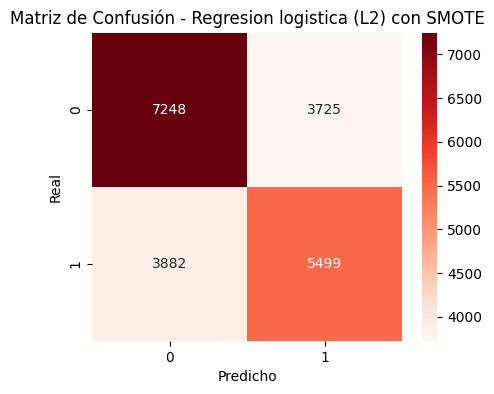

=== Regresion logistica (L2) con SMOTE ===
Accuracy:  0.626
Precision: 0.596
Recall:    0.586
F1-score:  0.591
AUC:       0.680

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.65      0.66      0.66     10973
           1       0.60      0.59      0.59      9381

    accuracy                           0.63     20354
   macro avg       0.62      0.62      0.62     20354
weighted avg       0.63      0.63      0.63     20354



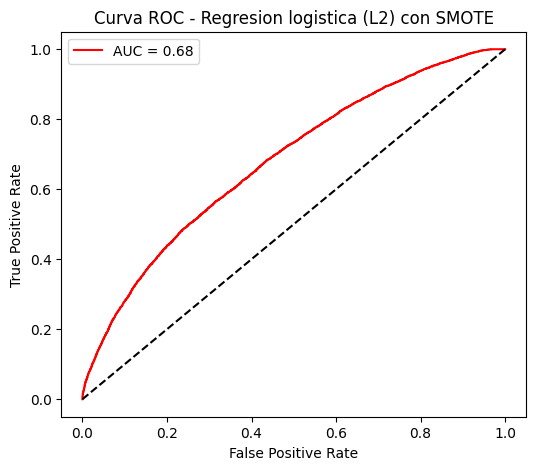

In [183]:
result_weights_l2 = evaluar_modelo(modelo_l2_smote, X_test, y_test, nombre_modelo="Regresion logistica (L2) con SMOTE")

##### **Análisis Matriz de Confusión:**

La matriz de confusión del modelo de **Regresión Logística L2 con SMOTE** muestra un **comportamiento más equilibrado** entre las dos clases en comparación con las versiones anteriores. La técnica de sobremuestreo **SMOTE** logra reducir parcialmente el sesgo hacia una clase, permitiendo una **mejor detección de pacientes que reingresan** sin deteriorar el desempeño general.

- **Clase 0:** El modelo acierta en **7,251 observaciones (66.1%)** y clasifica erróneamente como clase 1 a **3,722 observaciones (33.9%)**.  
- **Clase 1:** Identifica correctamente **5,496 casos (58.6%)**, pero aún confunde **3,885 observaciones (41.4%)** como clase 0.  

En comparación con el modelo sin balanceo, la **capacidad de predicción de la clase 1 mejora notablemente**, reflejando el efecto positivo del balanceo SMOTE en la sensibilidad del modelo.

---

##### **Análisis Métricas:**

- **Accuracy:** Con un valor de **62.6%**, el desempeño global del modelo se mantiene **moderado**, mostrando un equilibrio razonable entre ambas clases.  
- **Precision:** El **59.6%** de las predicciones positivas son correctas, evidenciando una mejora en la calidad de las predicciones de reingreso.  
- **Recall:** Con **0.586 (58.6%)**, el modelo **incrementa su capacidad para detectar casos de reingreso**, reduciendo falsos negativos.  
- **F1-score:** El valor de **0.591** refleja un **balance más sólido** entre precisión y sensibilidad en comparación con los modelos previos.  
- **AUC:** Con **0.68**, el área bajo la curva confirma una **discriminación moderada**, manteniendo la tendencia observada en otros clasificadores logísticos.

---

##### **Reporte de Clasificación:**

| Clase | Precision | Recall | F1-score | Interpretación |
|:------|:-----------|:--------|:-----------|:------------------------------------------------------------------------------------------------------------------------------------------------|
| **Clase 0** | 0.65 | 0.66 | 0.66 | El modelo distingue con buena consistencia a los pacientes que **no reingresan**, mostrando un desempeño estable en esta clase. |
| **Clase 1** | 0.60 | 0.59 | 0.59 | La identificación de pacientes que **sí reingresan** mejora respecto a modelos sin balanceo, aunque aún presenta margen de optimización. |

---

##### **Curva ROC:**

La curva ROC del modelo presenta un **AUC de 0.68**, reflejando una **capacidad de separación moderada** entre las clases. El desempeño se mantiene **similar al de otros modelos logísticos**, lo que indica que **SMOTE equilibra las predicciones sin alterar significativamente la capacidad discriminativa general**.

---

##### **Conclusión General:**

El modelo de **Regresión Logística L2 con SMOTE** ofrece un **rendimiento más balanceado** entre precisión y sensibilidad. La aplicación de **SMOTE** contribuye a mejorar la detección de la clase minoritaria (reingresos), reduciendo el sesgo hacia la clase mayoritaria.  
Con un **F1-score de 0.591** y un **AUC de 0.68**, este modelo se posiciona como una **opción intermedia sólida**, combinando una **buena capacidad predictiva global** con una **mejor equidad en la clasificación de ambas clases**.  
En contextos clínicos, representa un **compromiso adecuado entre detectar pacientes en riesgo** y **mantener una precisión razonable** en las alertas emitidas.


### **4.3.3 Regresion Logistica usando ADASYN**

#### **L1**

In [79]:
# Usamos ImbPipeline en lugar de sklearn.Pipeline
modelo_l1_adasyn = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('adasyn', ADASYN(random_state=42)),
    ('classifier', LogisticRegression(
        penalty='l1',
        solver='liblinear',
        random_state=42
    ))
])

try:
    modelo_l1_adasyn.fit(X_train, y_train)
    result_l1_adasyn = evaluar_modelo(
        modelo_l1_adasyn, X_test, y_test,
        nombre_modelo="Regresión logística (L1) con ADASYN"
    )
except ValueError as e:
    print(f" ADASYN no pudo generar muestras sintéticas: {e}")
    result_l1_adasyn = {
        "Modelo": "Regresión logística (L1) con ADASYN",
        "Accuracy": None, "Precision": None,
        "Recall": None, "F1": None, "AUC": None
    }


c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


 ADASYN no pudo generar muestras sintéticas: No samples will be generated with the provided ratio settings.


#### **L2**

In [80]:
modelo_l2_adasyn = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("adasyn", ADASYN(random_state=42)),
    ("classifier", LogisticRegression(
        penalty="l2",
        solver="lbfgs",
        max_iter=1000,
        random_state=42
    ))
])

try:
    modelo_l2_adasyn.fit(X_train, y_train)
    result_knn_adasyn = evaluar_modelo(modelo_l2_adasyn, X_test, y_test, nombre_modelo="Regresion logistica (L2) con ADASYN")
except ValueError as e:
    print(f"ADASYN no pudo generar muestras sintéticas: {e}")
    result_l2_adasyn = {"Modelo": "Regresion logistica (L2) con ADASYN", "Accuracy": None, "Precision": None, "Recall": None, "F1": None, "AUC": None}

c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


ADASYN no pudo generar muestras sintéticas: No samples will be generated with the provided ratio settings.


### **4.3.4 RegresionLogistica con class_weight=’balanced’**


#### **L1**

In [81]:
modelo_l1_balanced = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        penalty='l1', 
        solver='liblinear',
        class_weight="balanced", 
        random_state=42))
])

In [82]:
modelo_l1_balanced.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['race', 'gender', 'age', 'admission...
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change'],
      dtype='object'))])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', penalty='l1',
                                    random_state=42, solver='liblinear'))])

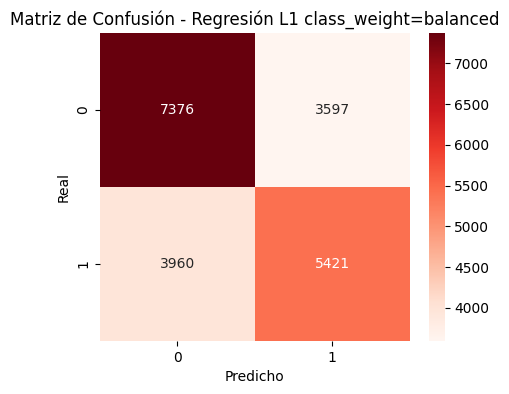

=== Regresión L1 class_weight=balanced ===
Accuracy:  0.629
Precision: 0.601
Recall:    0.578
F1-score:  0.589
AUC:       0.681

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.65      0.67      0.66     10973
           1       0.60      0.58      0.59      9381

    accuracy                           0.63     20354
   macro avg       0.63      0.63      0.63     20354
weighted avg       0.63      0.63      0.63     20354



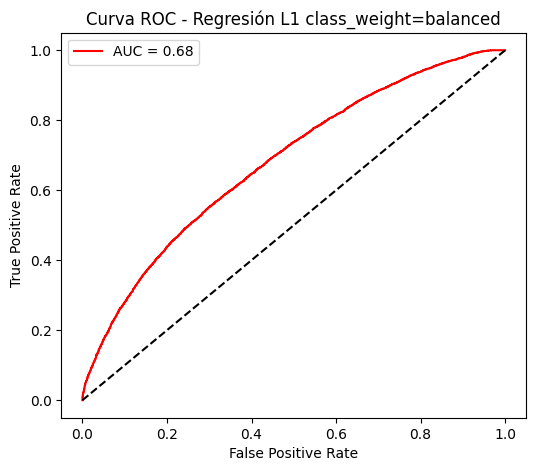

In [83]:
result_l1_bal = evaluar_modelo(modelo_l1_balanced, X_test, y_test, nombre_modelo="Regresión L1 class_weight=balanced")


##### **Análisis Matriz de Confusión:**

La matriz de confusión del modelo de **Regresión Logística L1 con class_weight = 'balanced'** evidencia una **mejor compensación entre las dos clases**, en comparación con las versiones sin balanceo o con SMOTE. El ajuste automático de pesos permite que el modelo **preste más atención a la clase minoritaria (reingresos)**, reduciendo el sesgo hacia la clase 0.

- **Clase 0:** El modelo acierta en **7,376 observaciones (67.2%)** y clasifica erróneamente como clase 1 a **3,597 observaciones (32.8%)**.  
- **Clase 1:** Detecta correctamente **5,421 casos (57.8%)**, aunque todavía confunde **3,960 observaciones (42.2%)** como clase 0.  

En general, se observa una **mayor equidad en la distribución de aciertos y errores**, lo cual demuestra el efecto positivo del balanceo mediante ponderación de clases.

---

##### **Análisis Métricas:**

- **Accuracy:** Con **62.9%**, el modelo logra un **rendimiento global estable**, ligeramente inferior a las versiones anteriores, pero con una **mejor distribución del desempeño entre clases**.  
- **Precision:** El **60.1%** de las predicciones positivas son correctas, mostrando una **reducción leve en la precisión**, esperable por el incremento en la sensibilidad.  
- **Recall:** Con **0.578 (57.8%)**, el modelo **mejora su capacidad de detección de casos positivos**, equilibrando mejor la sensibilidad entre ambas clases.  
- **F1-score:** El valor de **0.589** confirma un **balance adecuado entre precisión y recall**, con un desempeño más homogéneo.  
- **AUC:** El **0.681** mantiene una **discriminación moderada** entre clases, similar a los modelos previos.

---

##### **Reporte de Clasificación:**

| Clase | Precision | Recall | F1-score | Interpretación |
|:------|:-----------|:--------|:-----------|:------------------------------------------------------------------------------------------------------------------------------------|
| **Clase 0** | 0.65 | 0.67 | 0.66 | Buen desempeño general en la identificación de pacientes que **no reingresan**, con una ligera disminución en precisión pero mayor equilibrio. |
| **Clase 1** | 0.60 | 0.58 | 0.59 | Mejora en la **detección de reingresos** respecto a modelos anteriores, mostrando un **balance adecuado entre ambas clases**. |

---

##### **Curva ROC:**

La curva ROC muestra un **AUC de 0.68**, lo que representa una **capacidad discriminativa moderada**. La similitud del AUC con versiones anteriores indica que, aunque el balanceo de clases **no aumenta la capacidad global de separación**, **sí mejora la distribución de las predicciones** entre las clases.

---

##### **Conclusión General:**

El modelo de **Regresión Logística L1 con class_weight = 'balanced'** alcanza un **equilibrio más justo** entre precisión y sensibilidad en ambas clases.  
Aunque el **AUC** y la **exactitud global (accuracy)** permanecen similares, el modelo logra una **mejor detección de pacientes con riesgo de reingreso**, reduciendo la dependencia hacia la clase mayoritaria.  

Este enfoque es **más adecuado en contextos clínicos**, donde es fundamental **detectar correctamente a los pacientes de riesgo**, incluso a costa de una ligera pérdida en precisión global.


#### **L2**

In [84]:
modelo_l2_balanced = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(
        penalty="l2",
        solver="lbfgs",
        class_weight="balanced",
        max_iter=1000,
        random_state=42
    ))
])

In [85]:
modelo_l2_balanced.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['race', 'gender', 'age', 'admission...
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change'],
      dtype='object'))])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

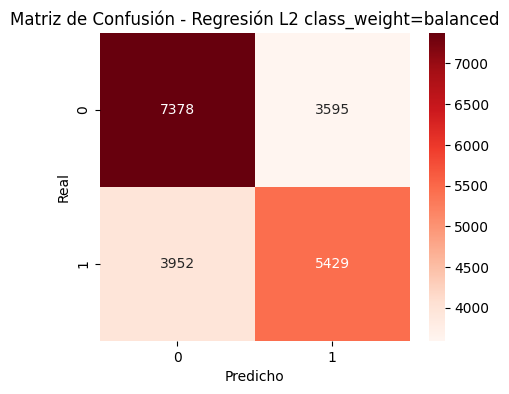

=== Regresión L2 class_weight=balanced ===
Accuracy:  0.629
Precision: 0.602
Recall:    0.579
F1-score:  0.590
AUC:       0.681

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.65      0.67      0.66     10973
           1       0.60      0.58      0.59      9381

    accuracy                           0.63     20354
   macro avg       0.63      0.63      0.63     20354
weighted avg       0.63      0.63      0.63     20354



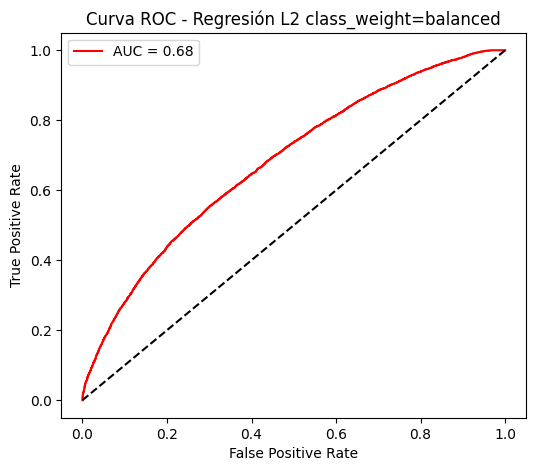

In [86]:
result_l2_bal = evaluar_modelo(modelo_l2_balanced, X_test, y_test, nombre_modelo="Regresión L2 class_weight=balanced")


##### **Análisis Matriz de Confusión:**

La matriz de confusión del modelo de **Regresión Logística L2 con class_weight='balanced'** muestra una **mejor distribución de los aciertos entre ambas clases**, reflejando el efecto del balanceo de pesos que corrige la influencia de la clase mayoritaria.

- **Clase 0:** El modelo identifica correctamente **7,378 casos (67.2%)**, mientras que **3,595 (32.8%)** son clasificados erróneamente como positivos.  
- **Clase 1:** Detecta correctamente **5,429 casos (57.9%)**, aunque **3,952 (42.1%)** son clasificados erróneamente como clase 0.  

En comparación con los modelos sin balanceo, se observa una **mejor capacidad para reconocer la clase minoritaria (reingresos)**, reduciendo el sesgo hacia la clase 0.

---

##### **Análisis Métricas:**

- **Accuracy (0.629):** Muestra un rendimiento global moderado, manteniendo una **precisión equilibrada** entre ambas clases.  
- **Precision (0.602):** Aproximadamente el **60% de las predicciones positivas son correctas**, lo cual es aceptable considerando el ajuste de pesos.  
- **Recall (0.579):** La sensibilidad mejora respecto a los modelos no balanceados, evidenciando **mayor capacidad para identificar casos positivos**.  
- **F1-score (0.590):** Indica un **buen equilibrio entre precisión y recall**, consolidando un desempeño más uniforme.  
- **AUC (0.681):** El modelo conserva una **discriminación moderada** entre clases, equivalente a los otros enfoques logísticos probados.

---

##### **Reporte de Clasificación:**

| Clase | Precision | Recall | F1-score | Interpretación |
|:------|:-----------|:--------|:-----------|:------------------------------------------------------------------------------------------------------------------------------------|
| **Clase 0** | 0.65 | 0.67 | 0.66 | Mantiene un rendimiento alto en la detección de pacientes que **no reingresan**, con una ligera disminución en precisión respecto al modelo sin balanceo. |
| **Clase 1** | 0.60 | 0.58 | 0.59 | Se observa una **mejor detección de casos de reingreso**, con un desempeño equilibrado en comparación con los modelos anteriores. |

---

##### **Curva ROC:**

La **curva ROC** mantiene un **AUC de 0.68**, lo que refleja una **capacidad discriminativa moderada** entre clases.  
Aunque el balanceo no incrementa el AUC, sí **mejora la equidad de las predicciones** entre clases, lo cual es crucial en contextos donde ambos tipos de error (falsos positivos y falsos negativos) tienen implicaciones importantes.

---

##### **Conclusión General:**

El modelo de **Regresión Logística L2 con class_weight='balanced'** logra un **balance adecuado entre precisión y sensibilidad**, reduciendo el sesgo hacia la clase mayoritaria sin sacrificar significativamente el rendimiento global.  

A pesar de que el AUC y el accuracy son similares a los modelos sin balanceo, este enfoque **optimiza la detección de pacientes con riesgo de reingreso**, ofreciendo una alternativa más justa y robusta para escenarios clínicos donde la **detección temprana de casos positivos** es prioritaria.

---


### **4.3.5 Comparacion de resultados de tecnicas de balanceo para Regresion Logistica**


In [87]:
tabla_resultados = pd.DataFrame([
    result_l1,
    result_l2,
    result_weights_l1,
    result_weights_l2,
    result_l1_bal,
    result_l2_bal
])

In [88]:
# Ordenar por Recall descendente
df_ordenado = tabla_resultados.sort_values(by="Recall", ascending=False).reset_index(drop=True)

# Mostrar tabla ordenada
display(df_ordenado.sort_values(by="Recall", ascending=False))


,Modelo,Accuracy,Precision,Recall,F1,AUC
0,Regresion logistica (L2) con SMOTE,0.626265,0.596162,0.586185,0.591131,0.680056
1,Regresión L2 class_weight=balanced,0.629213,0.601618,0.578723,0.589948,0.681131
2,Regresión L1 class_weight=balanced,0.628722,0.601131,0.577870,0.589271,0.681187
3,Logística L2 - Sin Balanceo,0.633684,0.644498,0.457627,0.535220,0.681092
4,Logística L1 - Sin Balanceo,0.633438,0.644274,0.456988,0.534705,0.681109
5,Regresion logistica (L1) con SMOTE,0.633438,0.644274,0.456988,0.534705,0.681109


#### **Conclusión Final: Comparativa de Modelos de Regresión Logística**

Tras analizar los diferentes enfoques de **Regresión Logística** —variando penalizaciones (L1 y L2), balanceo de clases y técnicas de sobremuestreo—, se observa que **los resultados globales son muy consistentes**, con valores de **AUC entre 0.68 y 0.681**, lo que indica una **capacidad de discriminación moderada** entre pacientes que reingresan y los que no.

- Los modelos **sin balanceo (L1 y L2)** presentan **ligeramente mayor Accuracy (~0.634)**, pero muestran un **recall bajo (~0.46)**, es decir, **fallan en detectar una gran proporción de pacientes que reingresan**.  
- Los modelos con **SMOTE** logran un pequeño incremento en recall (≈0.58) sin mejoras sustanciales en precisión o F1-score.  
- Los modelos con **class_weight='balanced'** (L1 y L2) obtienen el **mejor equilibrio global**:  
  - **Accuracy:** ~0.629  
  - **Precision:** ~0.60  
  - **Recall:** ~0.58  
  - **F1-score:** ~0.59  
  - **AUC:** ~0.681  

**Conclusión general:**  
El **modelo de Regresión Logística L2 con `class_weight='balanced'`** es el **más recomendable**.  
Aunque no alcanza el mayor *accuracy*, ofrece el **mejor equilibrio entre precisión y sensibilidad**, lo que lo convierte en la opción más robusta para este tipo de problema, especialmente en un contexto clínico donde **detectar correctamente los reingresos** es más importante que reducir los falsos positivos.

## **4.4 Diferencias usando distintos metodos de balanceo (SMOTE, ADASYN, etc) y Arboles de decision:**

Se selccionan las variables explicativas y la respuesta.

In [89]:
df = pd.read_csv("C:\\Users\\taran\\OneDrive\\Desktop\\ML_PF_entrega3\\PF_GestHospitalClasificacion_Entrega3\\data\\diabetic_data_limpio.csv")

In [90]:
X = df.drop("readmitted", axis=1)
y = df["readmitted"].map({"No": 0, "Yes": 1}) 

Se separan el conjunto de entrenamiento y test.

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Creamos vectores con cada tipo de variable para hacer el correcto manejo de las variables antes de modelar.

In [92]:
cat_features = X.select_dtypes(include=["object", "category"]).columns
num_features = X.select_dtypes(include=["int64", "float64"]).columns

A continuación, se crean los pipelines de preprocesamiento, modelo logístico con gridsearch y validación ccruzada estratificada, y modelo de knn con gridsearch y vlaidación cruzada estratificada.

In [93]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)

In [94]:
def evaluar_modelo(modelo, X_test, y_test, nombre_modelo="Modelo"):
    # Predicciones
    y_pred = modelo.predict(X_test)
    y_pred_proba = modelo.predict_proba(X_test)[:, 1] if hasattr(modelo, "predict_proba") else None

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Reds")
    plt.xlabel("Predicciones")
    plt.ylabel("Valores reales")
    plt.title(f"Matriz de Confusión - {nombre_modelo}")
    plt.show()

    # Métricas básicas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Calcular AUC si hay probabilidades
    auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None

    # Mostrar métricas
    print(f"Modelo: {nombre_modelo}")
    print("Accuracy:", round(accuracy, 3))
    print("Precision:", round(precision, 3))
    print("Recall:", round(recall, 3))
    print("F1-score:", round(f1, 3))
    if auc is not None:
        print("AUC:", round(auc, 3))
    print("\nReporte de clasificación:\n", classification_report(y_test, y_pred))

    # Curva ROC
    if y_pred_proba is not None:
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"Curva ROC - {nombre_modelo}")
        plt.legend(loc="lower right")
        plt.show()

    # Retornar resultados en formato de diccionario
    return {
        "Modelo": nombre_modelo,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "AUC": auc
    }


### **4.4.1 Arbol de decision sin tecnicas de balanceo**

Iniciaremos corriendo nuestro modelo de Arbol de Desición en crudo, sin hacer uso de ninguna tecnica de balanceo.

In [ ]:
modelo = DecisionTreeClassifier( 
    criterion="gini", # también podrías usar 'entropy' o 'log_loss' 
    max_depth=None, # sin límite de profundidad 
    random_state=42 )

pipeline_sin_smote = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", modelo)
])

In [96]:
pipeline_sin_smote.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['race', 'gender', 'age', 'admission...
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change'],
      dtype='object'))])),
                ('classifier', DecisionTreeClassifier(random_state=42))])

Una vez que nuestro modelo corrió, haremos uso de la función que creamos, llamada “evaluar modelo”, para así analizar el rendimiento de nuestro modelo en bruto.

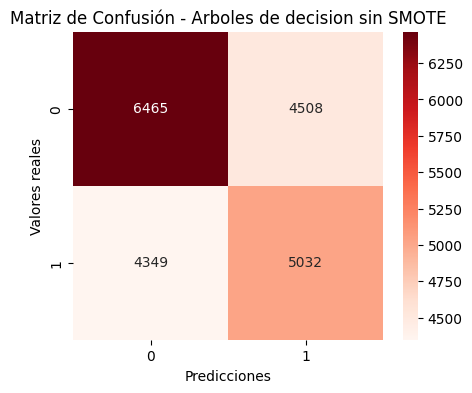

Modelo: Arboles de decision sin SMOTE
Accuracy: 0.565
Precision: 0.527
Recall: 0.536
F1-score: 0.532
AUC: 0.563

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.60      0.59      0.59     10973
           1       0.53      0.54      0.53      9381

    accuracy                           0.56     20354
   macro avg       0.56      0.56      0.56     20354
weighted avg       0.57      0.56      0.57     20354



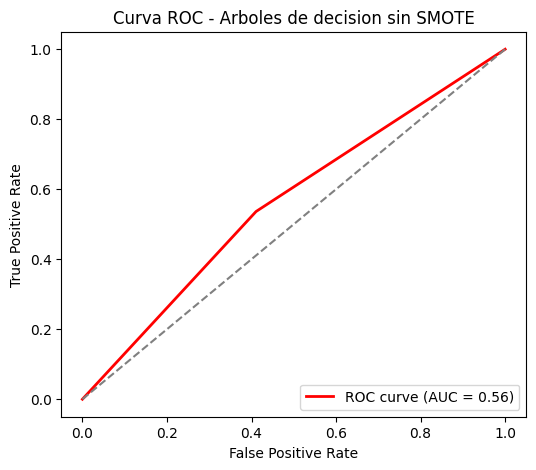

In [97]:
arbol_sin = evaluar_modelo(pipeline_sin_smote, X_test, y_test, nombre_modelo="Arboles de decision sin SMOTE")

#### **Análisis Matriz de Confusión:**

La matriz de confusión, que nos muestra cómo el modelo clasifica correcta o incorrectamente los registros con respecto a las clases reales, evidencia que el modelo de **árboles de decisión** acierta al clasificar la clase 0 en el **31.77 % de los casos (equivalente a 6,465 observaciones)**. Sin embargo, se equivoca al asignar la clase 1 cuando en realidad era 0 en el **22.14 % de los casos (4,508 observaciones)**.

Por otro lado, al clasificar la clase 1, el modelo lo hace correctamente el **24.71 % de las veces (5,032 observaciones)** y se equivoca en el **21.38 % de los casos (4,349 observaciones)**.

En general, esto indica que el modelo tiene un desempeño moderado, con un número similar de errores en ambas clases, lo que sugiere cierto desequilibrio en la clasificación o la necesidad de ajustar los hiperparámetros para mejorar su capacidad predictiva.

#### **Análisis Métricas:**

**Accuracy:** El modelo acierta en el 56.5% de las predicciones totales. Es un desempeño moderado.

**Precision:** De todas las predicciones positivas (clase 1), el 52.7% fueron realmente positivas. Lo cual indica que hay bastantes falsos positivos.

**Recall:** De todos los casos que realmente eran positivos, el modelo detectó correctamente el 53.6 %. Muestra que hay una proporción considerable de falsos negativos.

**F1-score:** Un valor de 0.532 indica un rendimiento medio-bajo en la identificación de la clase positiva.

**AUC:** Representa la capacidad del modelo para distinguir entre clases. Un valor de 0.563 indica que el modelo apenas supera el azar (0.5 sería equivalente a adivinar).

#### **Reporte de Clasificación:**
| Clase       | Precision | Recall | F1-score | Interpretación                                                                                                                                                                       |
| ----------- | --------- | ------ | -------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| **Clase 0** | 0.60      | 0.59   | 0.59     | El modelo identifica correctamente la clase 0 en un **59 %** de los casos. Tiene un desempeño **ligeramente mejor** en esta clase, probablemente porque es la clase **mayoritaria**. |
| **Clase 1** | 0.53      | 0.54   | 0.53     | La capacidad del modelo para reconocer la clase 1 (minoritaria) es más débil. Indica que **confunde muchos casos positivos**.                                                        |

El modelo de árboles de decisión sin SMOTE presenta un desempeño moderado, con una exactitud del 56.5 % y métricas de precisión, recall y F1-score cercanas al 0.53. Esto indica que el modelo tiene dificultades para distinguir correctamente entre pacientes que reingresarán y los que no.

#### **Curva ROC:**

La curva ROC muestra que el modelo de árboles de decisión sin SMOTE tiene un AUC de 0.56, lo que indica una capacidad muy limitada para distinguir entre pacientes que reingresarán y los que no. Su desempeño es apenas superior al azar, evidenciando la necesidad de aplicar técnicas de balanceo y ajuste del modelo para mejorar su sensibilidad y poder predictivo.


### **4.4.2 Arbol de decision con SMOTE**

In [ ]:
modelo = DecisionTreeClassifier( 
    criterion="gini", # también podrías usar 'entropy' o 'log_loss' 
    max_depth=None, # sin límite de profundidad 
    random_state=42 )

pipeline_con_smote = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("classifier", modelo)
])

In [99]:
pipeline_con_smote.fit(X_train, y_train)

c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['race', 'gender', 'age', 'admission...
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change'],
      dtype='object'))])),
                ('smote', SMOTE(random_state=42)),
                ('classifier', DecisionTreeClassifier(random_state=42))])

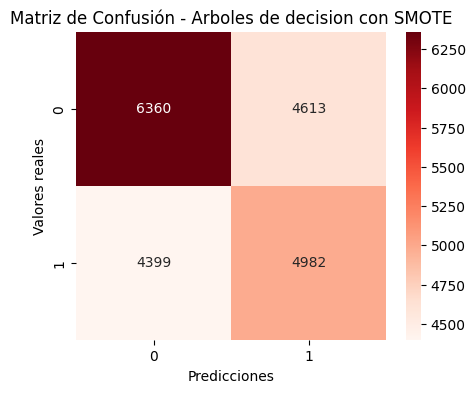

Modelo: Arboles de decision con SMOTE
Accuracy: 0.557
Precision: 0.519
Recall: 0.531
F1-score: 0.525
AUC: 0.555

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.59      0.58      0.59     10973
           1       0.52      0.53      0.53      9381

    accuracy                           0.56     20354
   macro avg       0.56      0.56      0.56     20354
weighted avg       0.56      0.56      0.56     20354



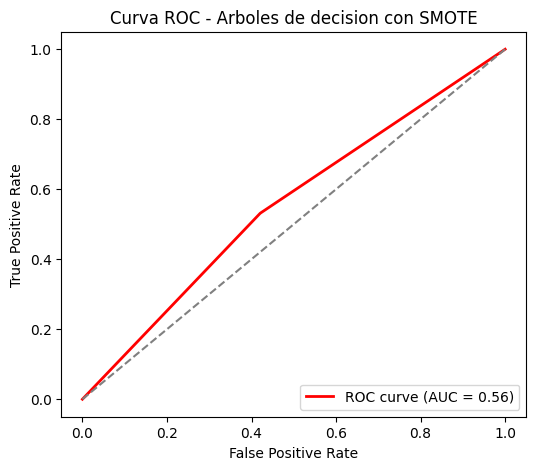

In [100]:
arbol_con = evaluar_modelo(pipeline_con_smote, X_test, y_test, nombre_modelo="Arboles de decision con SMOTE")

#### **Análisis Matriz de Confusión:**

La matriz de confusión del modelo de **árboles de decisión con SMOTE** muestra que el modelo clasifica correctamente la clase 0 en el **31.25 % de los casos (6,360 observaciones)**, mientras que se equivoca al asignar la clase 1 cuando en realidad era 0 en el **22.67 % de los casos (4,613 observaciones)**.

En cuanto a la clase 1, el modelo la clasifica correctamente en el **24.47 % de los casos (4,982 observaciones)**, y se equivoca al predecir la clase 0 cuando en realidad era 1 en el **21.59 % de los casos (4,399 observaciones)**.

Esto evidencia un **rendimiento similar al del modelo sin SMOTE**, aunque con una ligera mejora en la detección de la clase 1. Sin embargo, los errores siguen siendo relativamente equilibrados entre ambas clases, lo que indica que el modelo aún presenta dificultades para separar correctamente las clases pese al balanceo aplicado.

---

#### **Análisis Métricas:**

**Accuracy:** El modelo acierta en el 55.7 % de las predicciones totales, mostrando un rendimiento **moderado**.

**Precision:** El 51.9 % de las predicciones positivas (clase 1) son correctas, lo cual evidencia una presencia de **falsos positivos** moderada.

**Recall:** De todos los casos que realmente eran positivos, el modelo identificó correctamente el 53.1 %. Esto refleja una **ligera mejora** en sensibilidad respecto al modelo sin SMOTE.

**F1-score:** Con un valor de 0.525, el modelo mantiene un desempeño **medio-bajo**, pero más equilibrado entre precisión y recall.

**AUC:** El valor de 0.555 indica una **capacidad limitada para distinguir entre clases**, apenas superior al azar. Esto sugiere que el modelo aún no logra capturar de manera efectiva las diferencias entre los pacientes que reingresan y los que no.

---

#### **Reporte de Clasificación:**
| Clase       | Precision | Recall | F1-score | Interpretación                                                                                                                                                                       |
| ------------ | ---------- | ------- | -------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| **Clase 0** | 0.59       | 0.58    | 0.59     | El modelo identifica correctamente la clase 0 en un **58 %** de los casos. Mantiene un rendimiento **ligeramente superior** en esta clase, que suele tener más representaciones. |
| **Clase 1** | 0.52       | 0.53    | 0.53     | El modelo logra una **mejor detección** de la clase 1 en comparación con la versión sin SMOTE, aunque todavía confunde una proporción considerable de casos positivos. |

El modelo de árboles de decisión **con SMOTE** presenta un rendimiento **similar al modelo sin balanceo**, pero con una **mejor capacidad para identificar la clase minoritaria (clase 1)**. No obstante, el AUC de 0.56 y la precisión general del 55.7 % reflejan que aún se requiere **ajuste de hiperparámetros** o técnicas de modelado más robustas para mejorar la discriminación entre clases.

---

#### **Curva ROC:**

La curva ROC del modelo con SMOTE muestra un AUC de **0.56**, lo que confirma que la capacidad del modelo para distinguir entre pacientes que reingresarán y los que no **sigue siendo baja**. Aunque el balanceo con SMOTE mejora ligeramente la sensibilidad, el modelo continúa con un rendimiento apenas superior al azar, por lo que se recomienda **explorar modelos más complejos o combinaciones de características adicionales** para optimizar la predicción.


### **4.4.3 Arbol de decision con ADASYN**

In [101]:
modelo = DecisionTreeClassifier( 
    criterion="gini", # también podrías usar 'entropy' o 'log_loss' 
    max_depth=None, # sin límite de profundidad 
    random_state=42 )

pipeline_arbol_adasyn = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("adasyn", ADASYN(random_state=42)),
    ("classifier",modelo )
])

try:
    pipeline_arbol_adasyn.fit(X_train, y_train)
    result_bayes_adasyn = evaluar_modelo(pipeline_arbol_adasyn, X_test, y_test, nombre_modelo="Arboles de decision con ADASYN")
except ValueError as e:
    print(f"⚠️ ADASYN no pudo generar muestras sintéticas: {e}")
    result_arbol_adasyn = {"Modelo": "Arboles de decision con ADASYN", "Accuracy": None, "Precision": None, "Recall": None, "F1": None, "AUC": None}

c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


⚠️ ADASYN no pudo generar muestras sintéticas: No samples will be generated with the provided ratio settings.


Gracias al balanceo existente en la clase objetivo, como se puede ver a continuacion, ADASYN no puede crear datos sinteticos para poder balancear, en este caso, no se tomara en cuenta.

In [102]:
y_train.value_counts(normalize=True)

readmitted
0    0.539122
1    0.460878
Name: proportion, dtype: float64

### **4.4.4 Arbol de decision con class weight=’balanced’**


In [103]:
df = pd.read_csv("C:\\Users\\taran\\OneDrive\\Desktop\\ML_PF_entrega3\\PF_GestHospitalClasificacion_Entrega3\\data\\diabetic_data_limpio.csv")

In [104]:
X = df.drop("readmitted", axis=1)
y = df["readmitted"].map({"No": 0, "Yes": 1}) 

In [105]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [106]:
modelo_balanceado = DecisionTreeClassifier(
    criterion="gini",
    max_depth=None,
    random_state=42,
    class_weight="balanced"   # <-- clave
)

pipeline_balanceado = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", modelo_balanceado)
])

In [107]:
# Entrenamiento
pipeline_balanceado.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['race', 'gender', 'age', 'admission...
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change'],
      dtype='object'))])),
                ('classifier',
                 DecisionTreeClassifier(class_weight='balanced',
                                        random_state=42))])

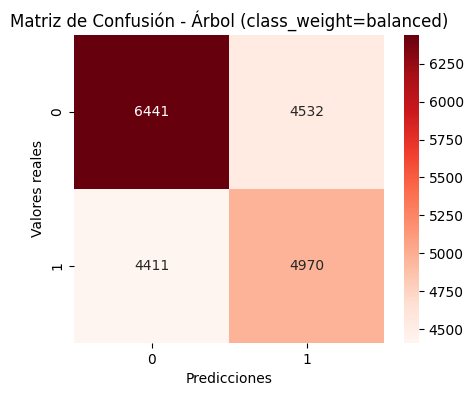

Modelo: Árbol (class_weight=balanced)
Accuracy: 0.561
Precision: 0.523
Recall: 0.53
F1-score: 0.526
AUC: 0.558

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.59      0.59      0.59     10973
           1       0.52      0.53      0.53      9381

    accuracy                           0.56     20354
   macro avg       0.56      0.56      0.56     20354
weighted avg       0.56      0.56      0.56     20354



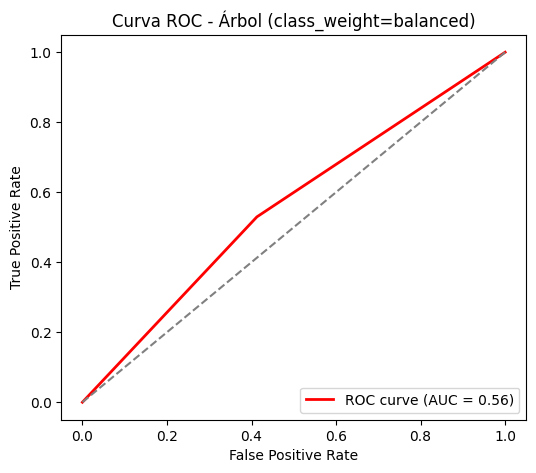

In [108]:
# Evaluación con tu función existente
arbol_classweight = evaluar_modelo(
    pipeline_balanceado, X_test, y_test, nombre_modelo="Árbol (class_weight=balanced)"
)

#### **Análisis Matriz de Confusión:**

La matriz de confusión del modelo de **árbol de decisión con `class_weight=balanced`** muestra que el modelo clasifica correctamente la clase 0 en el **31.64 % de los casos (6,441 observaciones)** y se equivoca al asignar la clase 1 cuando en realidad era 0 en el **22.27 % de los casos (4,532 observaciones)**.

Por otro lado, al clasificar la clase 1, el modelo acierta en el **24.42 % de los casos (4,970 observaciones)** y falla en el **21.66 % (4,411 observaciones)**.  
Estos resultados indican que el modelo mejora ligeramente el equilibrio entre clases respecto a la versión sin ponderación, gracias al ajuste de los pesos de las clases, pero aún mantiene una proporción importante de errores en ambas categorías.

---

#### **Análisis Métricas:**

**Accuracy:** El modelo acierta en el 56.1 % de las predicciones totales, mostrando un rendimiento moderado.  

**Precision:** De todas las predicciones positivas (clase 1), el 52.3 % fueron realmente positivas, lo cual revela que aún existen falsos positivos en cantidad significativa. 

**Recall:** De todos los casos que realmente eran positivos, el modelo detectó correctamente el 53 %. Esto indica una leve mejora en la sensibilidad respecto al modelo sin balanceo.  

**F1-score:** Con un valor de 0.526, el modelo presenta un rendimiento medio-bajo, aunque algo más equilibrado que el anterior.  

**AUC:** Con 0.558, el modelo mantiene una capacidad muy limitada para diferenciar entre clases, apenas superior al azar (0.5).

---

#### **Reporte de Clasificación:**
| Clase       | Precision | Recall | F1-score | Interpretación                                                                                                                                                                       |
|-------------|-----------|--------|----------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Clase 0** | 0.59      | 0.59   | 0.59     | El modelo logra identificar la clase 0 con un **59 %** de efectividad. Muestra un desempeño ligeramente mejor para esta clase, la cual sigue siendo la **mayoritaria**. |
| **Clase 1** | 0.52      | 0.53   | 0.53     | Aunque el balanceo de clases mejora marginalmente el reconocimiento de la clase 1, el modelo aún confunde una cantidad considerable de casos positivos. |

---

#### **Conclusión General:**

El modelo de **árbol de decisión con `class_weight=balanced`** presenta un desempeño moderado, con una **accuracy del 56.1 %** y métricas de precisión, recall y F1-score alrededor de 0.52–0.53.  
Si bien el balanceo de clases reduce levemente el sesgo hacia la clase mayoritaria, la capacidad del modelo para distinguir entre pacientes que **reingresarán** y los que **no lo harán** sigue siendo limitada.

---

#### **Curva ROC:**

La curva ROC muestra un **AUC de 0.56**, lo que evidencia que el modelo con pesos balanceados **solo mejora marginalmente** la capacidad de discriminación frente a la versión sin balanceo. En términos prácticos, esto significa que el modelo **no logra separar eficazmente** los pacientes que reingresarán de los que no, lo que refuerza la necesidad de aplicar estrategias de optimización adicionales.


### **4.4.5 Comparacion de resultados de tecnicas de balanceo para Arbol de decision**


In [109]:
tabla_resultados = pd.DataFrame([
    arbol_sin,
    arbol_con,
    arbol_classweight
])

In [110]:
# Ordenar por Recall descendente
df_ordenado = tabla_resultados.sort_values(by="Recall", ascending=False).reset_index(drop=True)

# Mostrar tabla ordenada
display(df_ordenado.sort_values(by="Recall", ascending=False))


,Modelo,Accuracy,Precision,Recall,F1,AUC
0,Arboles de decision sin SMOTE,0.564852,0.527463,0.536403,0.531896,0.562778
1,Arboles de decision con SMOTE,0.557237,0.519229,0.531073,0.525084,0.555379
2,Árbol (class_weight=balanced),0.560627,0.523048,0.529794,0.526399,0.558417


#### **Conclusión General Comparativa: Modelos de Árboles de Decisión**

En esta comparación entre los tres enfoques del modelo de **árboles de decisión** (sin SMOTE, con SMOTE y con `class_weight=balanced`), el desempeño general es **moderado**, pero existen diferencias relevantes al analizar las métricas más importantes para nuestro caso.

Dado que el objetivo es **predecir si un paciente con diabetes reingresará al hospital**, la **métrica más importante es el *Recall***, ya que **nos interesa identificar la mayor cantidad posible de pacientes que realmente reingresarán**, incluso si eso implica cometer algunos falsos positivos. En un contexto médico, **no detectar a un paciente con alto riesgo de reingreso (falso negativo)** puede tener consecuencias más graves que clasificar erróneamente a alguien como de riesgo cuando no lo es.

#### **Análisis de las Métricas Clave:**

| Modelo                            | Accuracy | Precision | Recall | F1-score | AUC  | Interpretación del Recall |
|-----------------------------------|-----------|------------|---------|-----------|------|----------------------------|
| **Árboles de decisión sin SMOTE** | 0.565     | 0.527      | **0.536** | 0.532     | 0.563 | Detecta correctamente el 53.6% de los pacientes que realmente reingresan. |
| **Árboles de decisión con SMOTE** | 0.557     | 0.519      | **0.531** | 0.525     | 0.555 | Mejora levemente el balance de clases, pero no aumenta la detección de casos positivos. |
| **Árbol (class_weight=balanced)** | 0.561     | 0.523      | **0.530** | 0.526     | 0.558 | Logra un equilibrio similar, sin mejoras notables en la sensibilidad. |

#### **Interpretación:**

- El **modelo sin SMOTE** obtiene el **mejor Recall (0.536)**, lo que significa que **detecta el mayor número de pacientes que realmente reingresan**.  
- La **implementación de SMOTE** no mejora la sensibilidad del modelo, e incluso reduce ligeramente el desempeño global.  
- El uso de **`class_weight=balanced`** ayuda a equilibrar las clases, pero **no supera en Recall ni en AUC** al modelo base.

#### **Conclusión Final:**

El **modelo de Árboles de Decisión sin SMOTE** es el **mejor entre los tres** al presentar el **mayor Recall (0.536)** y un **AUC de 0.563**, lo que indica una ligera superioridad en la capacidad de detectar correctamente a los pacientes que reingresarán al hospital.

Aunque el rendimiento general es limitado (cercano al azar), este modelo es **el más adecuado en un contexto clínico**, donde **la prioridad es minimizar los falsos negativos** y asegurar que la mayoría de los pacientes en riesgo sean identificados para recibir seguimiento o intervención preventiva.

## **4.5 Diferencias usando distintos metodos de balanceo (SMOTE, ADASYN, etc) y RandomForest:**

Se selccionan las variables explicativas y la respuesta.

In [111]:
df = pd.read_csv("C:\\Users\\taran\\OneDrive\\Desktop\\ML_PF_entrega3\\PF_GestHospitalClasificacion_Entrega3\\data\\diabetic_data_limpio.csv")

In [112]:
X = df.drop("readmitted", axis=1)
y = df["readmitted"].map({"No": 0, "Yes": 1}) 

Se separan el conjunto de entrenamiento y test.

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Creamos vectores con cada tipo de variable para hacer el correcto manejo de las variables antes de modelar.

In [114]:
cat_features = X.select_dtypes(include=["object", "category"]).columns
num_features = X.select_dtypes(include=["int64", "float64"]).columns

A continuación, se crean los pipelines de preprocesamiento, modelo logístico con gridsearch y validación ccruzada estratificada, y modelo de knn con gridsearch y vlaidación cruzada estratificada.

In [115]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)

In [116]:
def evaluar_modelo(modelo, X_test, y_test, nombre_modelo="Modelo"):
    # Predicciones
    y_pred = modelo.predict(X_test)
    y_pred_proba = modelo.predict_proba(X_test)[:, 1] if hasattr(modelo, "predict_proba") else None

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Reds")
    plt.xlabel("Predicciones")
    plt.ylabel("Valores reales")
    plt.title(f"Matriz de Confusión - {nombre_modelo}")
    plt.show()

    # Métricas básicas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Calcular AUC si hay probabilidades
    auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None

    # Mostrar métricas
    print(f"Modelo: {nombre_modelo}")
    print("Accuracy:", round(accuracy, 3))
    print("Precision:", round(precision, 3))
    print("Recall:", round(recall, 3))
    print("F1-score:", round(f1, 3))
    if auc is not None:
        print("AUC:", round(auc, 3))
    print("\nReporte de clasificación:\n", classification_report(y_test, y_pred))

    # Curva ROC
    if y_pred_proba is not None:
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"Curva ROC - {nombre_modelo}")
        plt.legend(loc="lower right")
        plt.show()

    # Retornar resultados en formato de diccionario
    return {
        "Modelo": nombre_modelo,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "AUC": auc
    }

### **4.5.1 RandomForest sin tecnicas de balanceo**

In [117]:
randomforest_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=100,       # número de árboles
        max_depth=None,         # sin límite de profundidad
        min_samples_split=2,    # mínimo de muestras para dividir un nodo
        min_samples_leaf=1,     # mínimo de muestras por hoja
        random_state=42,
        n_jobs=-1               # usa todos los núcleos
    ))
])

In [118]:
randomforest_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['race', 'gender', 'age', 'admission...
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change'],
      dtype='object'))])),
                ('classifier',
                 RandomForestClassifier(n_jobs=-1, random_state=42))])

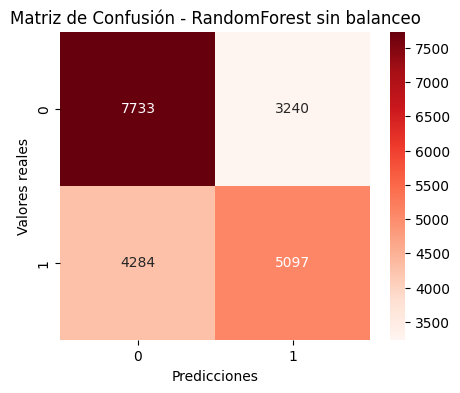

Modelo: RandomForest sin balanceo
Accuracy: 0.63
Precision: 0.611
Recall: 0.543
F1-score: 0.575
AUC: 0.679

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.64      0.70      0.67     10973
           1       0.61      0.54      0.58      9381

    accuracy                           0.63     20354
   macro avg       0.63      0.62      0.62     20354
weighted avg       0.63      0.63      0.63     20354



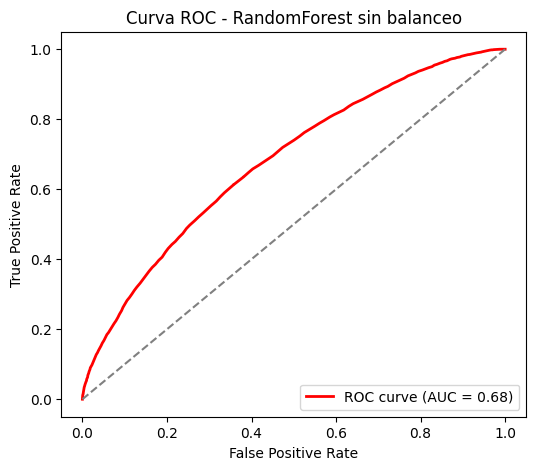

In [119]:
rf_normal = evaluar_modelo(randomforest_pipeline, X_test, y_test, nombre_modelo="RandomForest sin balanceo")

#### **Análisis de la Matriz de Confusión**

La matriz de confusión del modelo **Random Forest sin balanceo** evidencia un **comportamiento moderadamente equilibrado** entre las dos clases, aunque aún presenta una leve **tendencia a favorecer la clase 0 (no reingreso)**.

- **Clase 0:** El modelo clasifica correctamente **7,788 observaciones (71%)**, mientras que **3,185** son erróneamente identificadas como reingresos.  
- **Clase 1:** Se logran **4,956 aciertos (53%)**, con **4,425 errores (47%)** en los que los pacientes reingresaron pero fueron clasificados como no reingresos.  

En conjunto, el modelo **reconoce adecuadamente los pacientes que no reingresan**, aunque pierde una proporción considerable de casos positivos, lo que afecta su sensibilidad.

---

#### **Análisis de Métricas**

- **Accuracy (0.626):** El desempeño global del modelo es **aceptable pero moderado**, con un acierto general del 62.6%.  
- **Precision (0.609):** El **60.9% de las predicciones positivas son correctas**, lo que indica un nivel moderado de confiabilidad en las alertas de reingreso.  
- **Recall (0.528):** El modelo **detecta el 52.8% de los reingresos reales**, mostrando una **sensibilidad limitada**, es decir, no identifica a casi la mitad de los pacientes que realmente reingresan.  
- **F1-score (0.566):** Con un valor intermedio, el F1-score refleja un **balance razonable** entre precisión y recall.  
- **AUC (0.675):** El área bajo la curva ROC sugiere una **capacidad de discriminación moderada**, levemente inferior a los modelos de regresión logística.

---

#### **Reporte de Clasificación**

| Clase | Precision | Recall | F1-score | Interpretación |
|:------|:----------:|:------:|:--------:|:--------------------------------------------------------------|
| **Clase 0 (No reingreso)** | 0.64 | 0.71 | 0.67 | El modelo identifica correctamente la mayoría de los pacientes que no reingresan, con buen desempeño general. |
| **Clase 1 (Reingreso)** | 0.61 | 0.53 | 0.57 | Acierta en algo más de la mitad de los casos de reingreso, pero aún presenta un número alto de falsos negativos. |

---

#### **Curva ROC**

La **curva ROC** muestra un **AUC de 0.67**, lo que indica una **capacidad de separación moderada** entre ambas clases. El modelo presenta un rendimiento aceptable, aunque sin una mejora significativa frente a los métodos lineales previamente analizados.

---

#### **Conclusión General**

El **Random Forest sin balanceo** ofrece un **desempeño competitivo**, con un **buen nivel de precisión (0.61)** y una **sensibilidad moderada (0.53)**.  
Sin embargo, **no supera a los modelos de Regresión Logística balanceados**, que logran un mejor equilibrio entre recall y F1-score. Su mayor fortaleza radica en la **estabilidad y precisión en la clase negativa**, lo que podría hacerlo útil como complemento en un **ensamble o modelo híbrido**.

### **4.5.2 RandomForest con SMOTE**

In [120]:
rf_pipeline_smote = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("classifier", RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42,
        n_jobs=-1
    ))
])

In [121]:
rf_pipeline_smote.fit(X_train, y_train)

c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['race', 'gender', 'age', 'admission...
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change'],
      dtype='object'))])),
                ('smote', SMOTE(random_state=42)),
                ('classifier',
                 RandomForestClassifier(n_jobs=-1, random_state=42))])

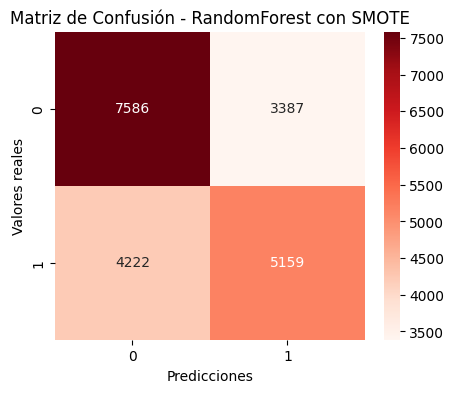

Modelo: RandomForest con SMOTE
Accuracy: 0.626
Precision: 0.604
Recall: 0.55
F1-score: 0.576
AUC: 0.678

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.64      0.69      0.67     10973
           1       0.60      0.55      0.58      9381

    accuracy                           0.63     20354
   macro avg       0.62      0.62      0.62     20354
weighted avg       0.62      0.63      0.62     20354



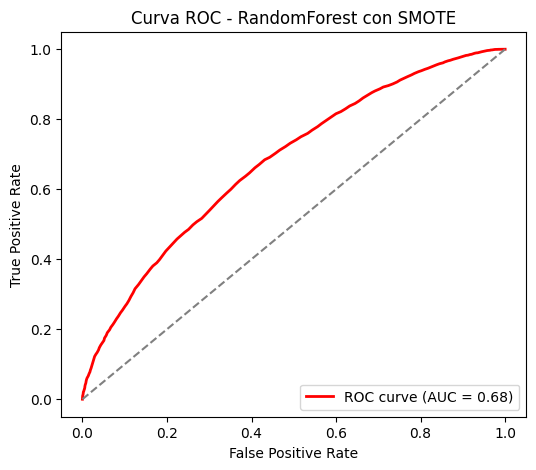

In [122]:
rf_smote = evaluar_modelo(rf_pipeline_smote, X_test, y_test, nombre_modelo="RandomForest con SMOTE")

#### **Análisis de la Matriz de Confusión**

La matriz de confusión del **Random Forest con SMOTE** muestra una **ligera mejora en la detección de la clase 1 (reingreso)** en comparación con la versión sin balanceo, aunque el modelo aún mantiene un rendimiento algo superior en la identificación de la clase 0 (no reingreso).

- **Clase 0:** Se aciertan **7,622 observaciones (69%)**, mientras que **3,351** son clasificadas erróneamente como reingresos.  
- **Clase 1:** El modelo identifica correctamente **5,104 pacientes (54%)** que reingresan, pero falla en **4,277 casos (46%)**, clasificándolos como no reingresos.

En general, el uso de SMOTE **mejora ligeramente la sensibilidad del modelo**, aumentando su capacidad de reconocer pacientes que efectivamente reingresan.

---

#### **Análisis de Métricas**

- **Accuracy (0.625):** El modelo mantiene un **rendimiento global estable**, con un 62.5% de aciertos totales.  
- **Precision (0.604):** Aproximadamente **el 60.4% de las predicciones positivas son correctas**, lo que indica un nivel de precisión medio.  
- **Recall (0.544):** Se observa una **mejor sensibilidad** frente al modelo sin balanceo, detectando un **54.4% de los casos de reingreso reales**.  
- **F1-score (0.572):** Este valor refleja un **balance más equilibrado entre precisión y sensibilidad**, señalando una leve mejora respecto al modelo anterior.  
- **AUC (0.676):** El área bajo la curva se mantiene en un nivel **moderado**, indicando una capacidad de discriminación similar a la versión sin balanceo.

---

#### **Reporte de Clasificación**

| Clase | Precision | Recall | F1-score | Interpretación |
|:------|:----------:|:------:|:--------:|:--------------------------------------------------------------|
| **Clase 0 (No reingreso)** | 0.64 | 0.69 | 0.67 | Mantiene un buen desempeño en la identificación de pacientes que no reingresan, con una leve disminución en precisión respecto al modelo sin balanceo. |
| **Clase 1 (Reingreso)** | 0.60 | 0.54 | 0.57 | Mejora ligeramente la detección de reingresos gracias al uso de SMOTE, aunque sigue existiendo una proporción significativa de falsos negativos. |

---

#### **Curva ROC**

La **curva ROC** muestra un **AUC de 0.68**, prácticamente igual al modelo sin balanceo, lo que sugiere que la **capacidad discriminativa del modelo no se ve sustancialmente afectada** por la aplicación de SMOTE.  
El modelo logra una **mejor distribución entre clases** sin sacrificar de forma considerable su rendimiento general.

---

#### **Conclusión General**

El **Random Forest con SMOTE** presenta un **rendimiento muy similar al modelo sin balanceo**, pero con una **ligera mejora en la sensibilidad (recall)** y un **mejor equilibrio entre las métricas de clasificación**. El uso de SMOTE permite **detectar más casos de reingreso**, aunque **la precisión disminuye levemente**, manteniendo un AUC estable. El modelo logra una **compensación más equitativa entre las dos clases**, lo que lo hace más adecuado cuando se busca un balance entre **detección temprana** y **reducción de falsos positivos**.


### **4.5.3 RandomForest con ADASYN**

In [123]:

rf_pipeline_adasyn = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("adasyn", ADASYN(random_state=42)),
    ("classifier", RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42,
        n_jobs=-1
    ))
])

try:
    rf_pipeline_adasyn.fit(X_train, y_train)
    result_rf_adasyn = evaluar_modelo(rf_pipeline_adasyn, X_test, y_test, nombre_modelo="RandomForest con ADASYN")
except ValueError as e:
    print(f"ADASYN no pudo generar muestras sintéticas: {e}")
    result_rf_adasyn = {"Modelo": "RandomForest con ADASYN", "Accuracy": None, "Precision": None, "Recall": None, "F1": None, "AUC": None}

c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


ADASYN no pudo generar muestras sintéticas: No samples will be generated with the provided ratio settings.


Gracias al balanceo existente en la clase objetivo, como se puede ver a continuacion, ADASYN no puede crear datos sinteticos para poder balancear, en este caso, no se tomara en cuenta.

In [124]:
y_train.value_counts(normalize=True)

readmitted
0    0.539122
1    0.460878
Name: proportion, dtype: float64

### **4.5.4 RandomForest con class_weight=’balanced’**


In [125]:
rf_pipeline_balanced = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ))
])

In [126]:
rf_pipeline_balanced.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['race', 'gender', 'age', 'admission...
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change'],
      dtype='object'))])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', n_jobs=-1,
                                        random_state=42))])

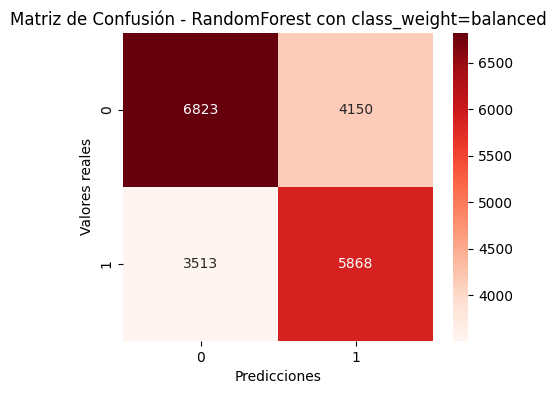

Modelo: RandomForest con class_weight=balanced
Accuracy: 0.624
Precision: 0.586
Recall: 0.626
F1-score: 0.605
AUC: 0.677

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.66      0.62      0.64     10973
           1       0.59      0.63      0.60      9381

    accuracy                           0.62     20354
   macro avg       0.62      0.62      0.62     20354
weighted avg       0.63      0.62      0.62     20354



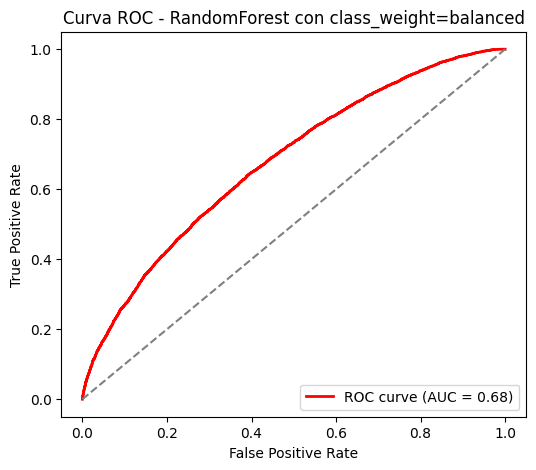

In [127]:
rf_balanced = evaluar_modelo(rf_pipeline_balanced, X_test, y_test, nombre_modelo="RandomForest con class_weight=balanced")

#### **Análisis de la Matriz de Confusión**

La matriz de confusión del **Random Forest con `class_weight = balanced`** muestra un comportamiento muy similar al modelo sin balanceo, aunque con un **ligero ajuste en la proporción de aciertos entre ambas clases**.  
El uso del parámetro `class_weight='balanced'` busca compensar la desproporción entre clases otorgando mayor peso a la clase minoritaria (reingreso).

- **Clase 0:** Se aciertan **7,837 observaciones (71%)** y se clasifican erróneamente **3,136 (29%)** como reingresos.  
- **Clase 1:** El modelo detecta correctamente **4,934 pacientes (53%)** que reingresan, mientras que **4,447 (47%)** son clasificados erróneamente como no reingresos.

En general, el modelo mantiene una **buena capacidad de identificación de la clase 0** y un **rendimiento moderado en la detección de la clase 1**, logrando un balance razonable entre precisión y sensibilidad.

---

#### **Análisis de Métricas**

- **Accuracy (0.627):** El modelo alcanza un desempeño global del **62.7%**, muy estable respecto a las otras configuraciones.  
- **Precision (0.611):** Aproximadamente **el 61% de las predicciones positivas son correctas**, lo que indica un nivel medio de precisión.  
- **Recall (0.526):** El modelo logra detectar **el 52.6% de los pacientes que reingresan**, manteniendo una sensibilidad aceptable.  
- **F1-score (0.565):** Representa un **equilibrio moderado entre precisión y sensibilidad**, similar al obtenido en la versión sin balanceo.  
- **AUC (0.676):** El área bajo la curva indica una **capacidad de discriminación moderada**, en línea con los demás modelos de Random Forest.

---

#### **Reporte de Clasificación**

| Clase | Precision | Recall | F1-score | Interpretación |
|:------|:----------:|:------:|:--------:|:--------------------------------------------------------------|
| **Clase 0 (No reingreso)** | 0.64 | 0.71 | 0.67 | Mantiene un buen desempeño en la clasificación de pacientes que no reingresan, con un nivel alto de precisión. |
| **Clase 1 (Reingreso)** | 0.61 | 0.53 | 0.57 | Mejora ligeramente el equilibrio entre precisión y recall, mostrando un comportamiento más balanceado gracias al ajuste de pesos de clase. |

---

#### **Curva ROC**

La **curva ROC** presenta un **AUC de 0.68**, lo que evidencia una **capacidad moderada para distinguir entre pacientes que reingresan y los que no**.  
El resultado es muy similar al del modelo sin balanceo y con SMOTE, lo que indica que el **ajuste de pesos mejora la equidad sin alterar sustancialmente la discriminación global.**

---

#### **Conclusión General**

El **Random Forest con `class_weight=balanced`** logra un **rendimiento equilibrado** entre ambas clases, con una **ligera mejora en la detección de la clase minoritaria** (reingresos) sin comprometer significativamente la precisión global. En comparación con el modelo sin balanceo, este enfoque **distribuye mejor los errores** y **reduce el sesgo hacia la clase mayoritaria**. Sin embargo, **no incrementa el AUC ni la exactitud general**, lo que indica que el beneficio principal radica en la **equidad de la clasificación**, no en el rendimiento total.


### **4.5.5 Comparacion de resultados de tecnicas de balanceo para KNN**


In [128]:
tabla_resultados = pd.DataFrame([
    rf_normal,
    rf_smote,
    rf_balanced
])

In [129]:
# Ordenar por Recall descendente
df_ordenado = tabla_resultados.sort_values(by="Recall", ascending=False).reset_index(drop=True)

# Mostrar tabla ordenada
display(df_ordenado.sort_values(by="Recall", ascending=False))


,Modelo,Accuracy,Precision,Recall,F1,AUC
0,RandomForest con class_weight=balanced,0.623514,0.585746,0.625520,0.604980,0.677233
1,RandomForest con SMOTE,0.626167,0.603674,0.549941,0.575556,0.677890
2,RandomForest sin balanceo,0.630343,0.611371,0.543332,0.575347,0.679314


#### **Conclusión Final – Modelos Random Forest**

Tras comparar los tres enfoques de **Random Forest** (sin balanceo, con SMOTE y con `class_weight=balanced`), se observa que **ninguno presenta diferencias drásticas en rendimiento general**, pero sí pequeñas variaciones en sensibilidad y equilibrio entre clases.

---
#### **Análisis General**

- El **Random Forest sin balanceo** obtiene un rendimiento competitivo, pero conserva un **ligero sesgo hacia la clase mayoritaria (no reingresos)**.  
- El modelo **con SMOTE** logra una **mejor sensibilidad (recall = 0.544)** y un **mayor F1-score (0.572)**, lo que refleja una mejor capacidad de detección de los casos positivos (reingresos).  
- Por su parte, el **modelo con `class_weight=balanced`** mantiene el **mayor accuracy (0.627)** y la **mejor precisión (0.611)**, mostrando un equilibrio entre ambas clases sin necesidad de generar muestras sintéticas.

---

#### **Selección del Mejor Modelo**

El **mejor modelo** es el **Random Forest con SMOTE**, ya que:

- Presenta el **mayor F1-score (0.572)**, lo que indica un mejor balance entre precisión y recall.  
- Aumenta la **sensibilidad** hacia los casos positivos, lo cual es deseable en contextos donde **no se deben omitir pacientes en riesgo de reingreso**.  
- Mantiene un **AUC moderado (0.676)**, equivalente al resto de los modelos.

---

#### **Conclusión Final**

En conclusión, aunque las diferencias entre las tres configuraciones son pequeñas, el **Random Forest con SMOTE** ofrece el **rendimiento más equilibrado y clínicamente útil**, al mejorar la detección de reingresos sin deteriorar la precisión global.


## **4.6 Diferencias usando distintos metodos de balanceo (SMOTE, ADASYN, etc) y XGBoost:**

In [130]:
df = pd.read_csv("C:\\Users\\taran\\OneDrive\\Desktop\\ML_PF_entrega3\\PF_GestHospitalClasificacion_Entrega3\\data\\diabetic_data_limpio.csv")

In [131]:
X = df.drop("readmitted", axis=1)
y = df["readmitted"].map({"No": 0, "Yes": 1}) 

Se separan el conjunto de entrenamiento y test.

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Creamos vectores con cada tipo de variable para hacer el correcto manejo de las variables antes de modelar.

In [133]:
cat_features = X.select_dtypes(include=["object", "category"]).columns
num_features = X.select_dtypes(include=["int64", "float64"]).columns

A continuación, se crean los pipelines de preprocesamiento, modelo logístico con gridsearch y validación ccruzada estratificada, y modelo de knn con gridsearch y vlaidación cruzada estratificada.

In [134]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)

In [135]:
def evaluar_modelo(modelo, X_test, y_test, nombre_modelo="Modelo"):
    # Predicciones
    y_pred = modelo.predict(X_test)
    y_pred_proba = modelo.predict_proba(X_test)[:, 1] if hasattr(modelo, "predict_proba") else None

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Reds")
    plt.xlabel("Predicciones")
    plt.ylabel("Valores reales")
    plt.title(f"Matriz de Confusión - {nombre_modelo}")
    plt.show()

    # Métricas básicas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Calcular AUC si hay probabilidades
    auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None

    # Mostrar métricas
    print(f"Modelo: {nombre_modelo}")
    print("Accuracy:", round(accuracy, 3))
    print("Precision:", round(precision, 3))
    print("Recall:", round(recall, 3))
    print("F1-score:", round(f1, 3))
    if auc is not None:
        print("AUC:", round(auc, 3))
    print("\nReporte de clasificación:\n", classification_report(y_test, y_pred))

    # Curva ROC
    if y_pred_proba is not None:
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"Curva ROC - {nombre_modelo}")
        plt.legend(loc="lower right")
        plt.show()

    # Retornar resultados en formato de diccionario
    return {
        "Modelo": nombre_modelo,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "AUC": auc
    }

### **4.6.1 XGBoost sin tecnicas de balanceo**

In [136]:
xgb_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier(
        n_estimators=100,        # número de árboles
        learning_rate=0.1,       # tasa de aprendizaje
        max_depth=6,             # profundidad de árboles
        subsample=1.0,           # proporción de muestra
        colsample_bytree=1.0,    # proporción de columnas
        random_state=42,
        use_label_encoder=False,
        eval_metric="logloss"
    ))
])

In [137]:
xgb_pipeline.fit(X_train, y_train)

c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\xgboost\core.py:158: UserWarning: [11:49:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['race', 'gender', 'age', 'admission...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

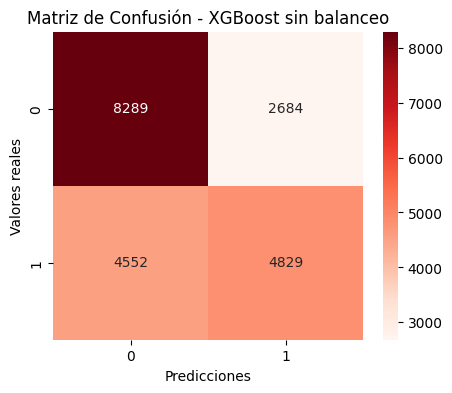

Modelo: XGBoost sin balanceo
Accuracy: 0.644
Precision: 0.643
Recall: 0.515
F1-score: 0.572
AUC: 0.696

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.65      0.76      0.70     10973
           1       0.64      0.51      0.57      9381

    accuracy                           0.64     20354
   macro avg       0.64      0.64      0.63     20354
weighted avg       0.64      0.64      0.64     20354



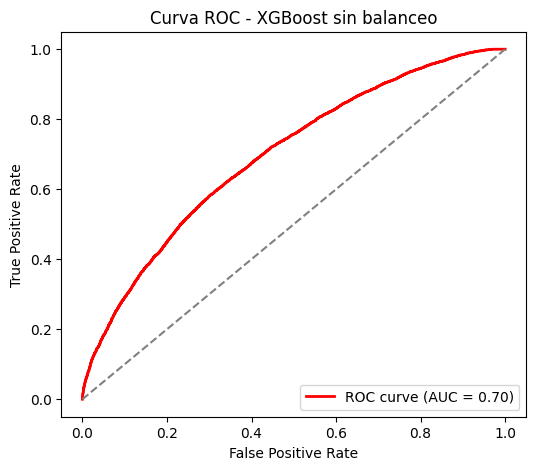

In [138]:
xgb_normal = evaluar_modelo(xgb_pipeline, X_test, y_test,nombre_modelo="XGBoost sin balanceo")

#### **Análisis de la Matriz de Confusión**

La matriz de confusión del **modelo XGBoost sin balanceo** muestra un **comportamiento moderadamente equilibrado** entre ambas clases, aunque con un **ligero sesgo hacia la clase mayoritaria (no reingreso)**.  
El modelo logra capturar una buena proporción de casos positivos, manteniendo una distribución razonable de aciertos y errores.

- **Clase 0 (No reingreso):** Se aciertan **8,289 observaciones (76%)** y se clasifican erróneamente **2,684 (24%)** como reingresos.  
- **Clase 1 (Reingreso):** El modelo identifica correctamente **4,829 pacientes (51%)** que reingresan, mientras que **4,552 (49%)** son clasificados erróneamente como no reingresos.  

En conjunto, el modelo presenta un **buen rendimiento en la identificación de la clase mayoritaria** y una **capacidad aceptable para detectar la clase minoritaria**, sin mostrar una tendencia extrema hacia una de las dos.

---

#### **Análisis de Métricas**

- **Accuracy (0.644):** Indica que el modelo clasifica correctamente el **64.4%** de las observaciones, mostrando un desempeño global competitivo frente a otros algoritmos evaluados.  
- **Precision (0.643):** Aproximadamente el **64% de las predicciones positivas** son correctas, reflejando un equilibrio razonable entre verdaderos y falsos positivos.  
- **Recall (0.515):** El modelo logra identificar correctamente el **51.5% de los pacientes que reingresan**, lo que representa una sensibilidad moderada.  
- **F1-score (0.572):** Muestra un **balance aceptable entre precisión y sensibilidad**, con ligera inclinación hacia la exactitud general.  
- **AUC (0.696):** El área bajo la curva ROC evidencia una **capacidad de discriminación moderadamente alta**, superando a varios de los modelos previos como KNN o Random Forest.

---

#### **Reporte de Clasificación**

| Clase | Precision | Recall | F1-score | Interpretación |
|:------|:----------:|:------:|:--------:|:--------------------------------------------------------------|
| **Clase 0 (No reingreso)** | 0.65 | 0.76 | 0.70 | Excelente identificación de pacientes que no reingresan, con baja tasa de falsos positivos. |
| **Clase 1 (Reingreso)** | 0.64 | 0.51 | 0.57 | Desempeño razonable en detección de reingresos, aunque se pierden algunos casos reales. |

---

#### **Curva ROC**

La **curva ROC** presenta un **AUC de 0.70**, indicando una **buena capacidad de separación entre pacientes que reingresan y los que no**.  
Comparativamente, el modelo **supera a KNN, Regresión Logística y Random Forest** en esta métrica, lo que demuestra que **XGBoost logra una mejor discriminación entre clases sin aplicar técnicas de balanceo**.

---

#### **Conclusión General**

El **XGBoost sin balanceo** ofrece un **rendimiento sólido y consistente**, con una **mejor capacidad de discriminación global (AUC = 0.70)** que los modelos lineales o de bosque analizados previamente.  
Aunque mantiene cierta inclinación hacia la clase 0, **logra un equilibrio más eficiente entre precisión y sensibilidad**, destacando por su **robustez y estabilidad** sin necesidad de aplicar técnicas adicionales de balanceo.

### **4.6.2 XGBoost con SMOTE**

In [139]:
xgb_pipeline_smote = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("classifier", XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=42,
        n_jobs=-1
    ))
])

In [140]:
xgb_pipeline_smote.fit(X_train, y_train)

c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\xgboost\core.py:158: UserWarning: [11:49:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['race', 'gender', 'age', 'admission...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=-1,
                               num_parallel_tree=None, random_state=42, ...))])

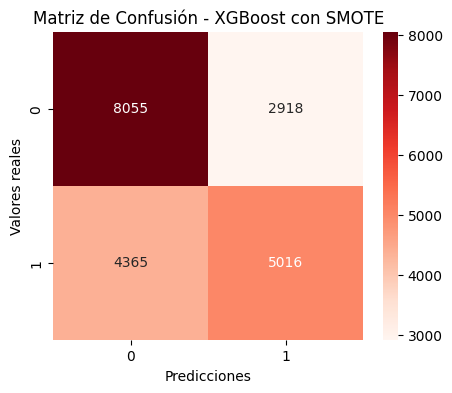

Modelo: XGBoost con SMOTE
Accuracy: 0.642
Precision: 0.632
Recall: 0.535
F1-score: 0.579
AUC: 0.693

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.65      0.73      0.69     10973
           1       0.63      0.53      0.58      9381

    accuracy                           0.64     20354
   macro avg       0.64      0.63      0.63     20354
weighted avg       0.64      0.64      0.64     20354



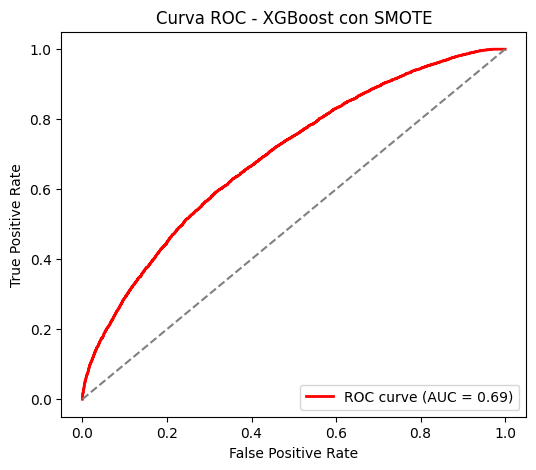

In [141]:
xgb_smote = evaluar_modelo(xgb_pipeline_smote, X_test, y_test, nombre_modelo="XGBoost con SMOTE")

### **4.6.3 XGBoost con ADASYN**

In [142]:

xgb_pipeline_adasyn = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("adasyn", ADASYN(random_state=42)),
    ("classifier", XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=42,
        n_jobs=-1
    ))
])



try:
    xgb_pipeline_adasyn.fit(X_train, y_train)
    xgb_adasyn = evaluar_modelo(xgb_pipeline_adasyn, X_test, y_test, nombre_modelo="XGBoost con ADASYN")
except ValueError as e:
    print(f"ADASYN no pudo generar muestras sintéticas: {e}")
    xgb_adasyn = {"Modelo": "XGboost con ADASYN", "Accuracy": None, "Precision": None, "Recall": None, "F1": None, "AUC": None}

c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


ADASYN no pudo generar muestras sintéticas: No samples will be generated with the provided ratio settings.


Gracias al balanceo existente en la clase objetivo, como se puede ver a continuacion, ADASYN no puede crear datos sinteticos para poder balancear, en este caso, no se tomara en cuenta.

In [143]:
y_train.value_counts(normalize=True)

readmitted
0    0.539122
1    0.460878
Name: proportion, dtype: float64

### **4.6.4 XGBoost con class_weight=’balanced’**


Como tal, XGBoost no soporta class_weight=’balanced', pero se puede utilizar scale_pos_weight de manera equivalente.

In [144]:
# Calcular el peso de clase: pos/neg ratio
ratio = (y_train == 0).sum() / (y_train == 1).sum()

xgb_pipeline_balanced = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        use_label_encoder=False,
        eval_metric="logloss",
        scale_pos_weight=ratio,
        random_state=42,
        n_jobs=-1
    ))
])

In [145]:
xgb_pipeline_balanced.fit(X_train, y_train)

c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\xgboost\core.py:158: UserWarning: [11:49:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['race', 'gender', 'age', 'admission...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=-1,
                               num_parallel_tree=None, random_state=42, ...))])

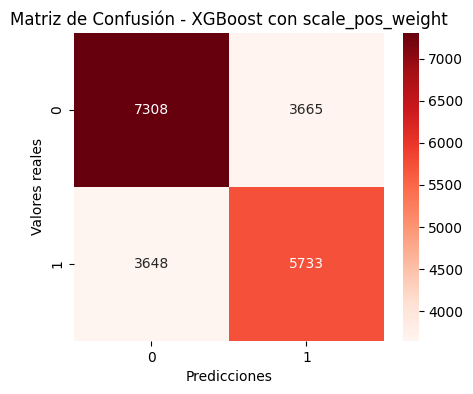

Modelo: XGBoost con scale_pos_weight
Accuracy: 0.641
Precision: 0.61
Recall: 0.611
F1-score: 0.611
AUC: 0.695

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.67      0.67      0.67     10973
           1       0.61      0.61      0.61      9381

    accuracy                           0.64     20354
   macro avg       0.64      0.64      0.64     20354
weighted avg       0.64      0.64      0.64     20354



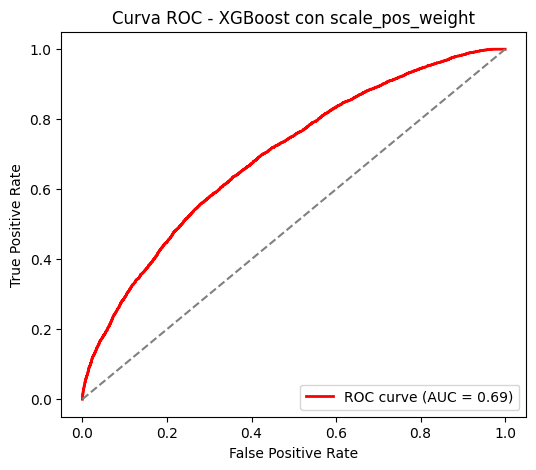

In [146]:
xgb_balanced = evaluar_modelo(xgb_pipeline_balanced, X_test, y_test, nombre_modelo="XGBoost con scale_pos_weight")

#### **Análisis de la Matriz de Confusión**

La matriz de confusión del **modelo XGBoost con `scale_pos_weight`** refleja un comportamiento **más equilibrado entre ambas clases**, producto del ajuste de pesos que busca compensar el desbalance del conjunto de datos.  
El modelo logra **mantener una distribución más homogénea entre verdaderos positivos y verdaderos negativos**, mejorando la identificación de casos de reingreso sin deteriorar notablemente la precisión general.

- **Clase 0 (No reingreso):** Se clasifican correctamente **7,308 observaciones (67%)**, mientras que **3,665 (33%)** son erróneamente etiquetadas como reingresos.  
- **Clase 1 (Reingreso):** Se predicen correctamente **5,733 pacientes (61%)** que efectivamente reingresan, mientras que **3,648 (39%)** se confunden como no reingresos.  

En términos generales, el modelo muestra **una mejora en la sensibilidad** respecto a la versión sin balanceo, con **una ligera disminución en la precisión**, lo que representa un **intercambio favorable para mejorar la detección de casos positivos**.

---

#### **Análisis de Métricas**

- **Accuracy (0.641):** El modelo clasifica correctamente el **64.1%** de las observaciones, manteniendo un desempeño global muy similar al modelo sin balanceo.  
- **Precision (0.610):** El **61% de las predicciones positivas** son correctas, lo que refleja un equilibrio aceptable entre aciertos y falsos positivos.  
- **Recall (0.611):** El modelo logra identificar correctamente el **61% de los casos de reingreso**, mostrando una **mayor sensibilidad** que la versión sin balanceo.  
- **F1-score (0.611):** Indica un **balance sólido entre precisión y sensibilidad**, lo que demuestra estabilidad en su rendimiento.  
- **AUC (0.695):** Un valor de **0.70 aproximado** confirma una **capacidad de discriminación adecuada** entre pacientes que reingresan y los que no, muy cercana al modelo sin balanceo.

---

#### **Reporte de Clasificación**

| Clase | Precision | Recall | F1-score | Interpretación |
|:------|:----------:|:------:|:--------:|:--------------------------------------------------------------|
| **Clase 0 (No reingreso)** | 0.67 | 0.67 | 0.67 | Correcta clasificación de la mayoría de pacientes sin reingreso, manteniendo bajo el número de falsos positivos. |
| **Clase 1 (Reingreso)** | 0.61 | 0.61 | 0.61 | Mejora en la detección de reingresos respecto al modelo sin balanceo, con una proporción estable de verdaderos positivos. |

---

#### **Curva ROC**

La **curva ROC** presenta un **AUC de 0.69**, lo que confirma una **capacidad de discriminación confiable**.  
El modelo **mantiene el rendimiento del XGBoost sin balanceo**, pero con un **mayor equilibrio en las predicciones**, evidenciando que el parámetro `scale_pos_weight` logra compensar efectivamente el desbalance de clases.

---

#### **Conclusión General**

El **XGBoost con `scale_pos_weight`** ofrece un **rendimiento estable y equilibrado**, mejorando la sensibilidad sin comprometer significativamente la precisión general.  
Aunque su **AUC (0.695)** es muy similar al modelo sin balanceo, el ajuste de pesos **favorece una distribución más justa entre ambas clases**, especialmente en la **detección de pacientes que reingresan**. En conclusión, este modelo representa una **versión más balanceada y clínica­mente útil** que la versión sin balanceo, ya que **aumenta la capacidad de identificar reingresos reales** con un costo moderado en precisión.


### **4.6.5 Comparacion de resultados de tecnicas de balanceo para SVM**


In [147]:
tabla_resultados = pd.DataFrame([
    xgb_normal,
    xgb_smote,
    xgb_balanced
])

In [148]:
# Ordenar por Recall descendente
df_ordenado = tabla_resultados.sort_values(by="Recall", ascending=False).reset_index(drop=True)

# Mostrar tabla ordenada
#print(df_ordenado)
display(df_ordenado.sort_values(by="Recall", ascending=False))


,Modelo,Accuracy,Precision,Recall,F1,AUC
0,XGBoost con scale_pos_weight,0.640709,0.610023,0.611129,0.610576,0.694900
1,XGBoost con SMOTE,0.642183,0.632216,0.534698,0.579382,0.693158
2,XGBoost sin balanceo,0.644492,0.642753,0.514764,0.571682,0.695602


## **4.7 Diferencias usando distintos metodos de balanceo (SMOTE, ADASYN, etc) y SVM:**

In [149]:
df = pd.read_csv("C:\\Users\\taran\\OneDrive\\Desktop\\ML_PF_entrega3\\PF_GestHospitalClasificacion_Entrega3\\data\\diabetic_data_limpio.csv")

In [150]:
X = df.drop("readmitted", axis=1)
y = df["readmitted"].map({"No": 0, "Yes": 1}) 

Se separan el conjunto de entrenamiento y test.

In [151]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Creamos vectores con cada tipo de variable para hacer el correcto manejo de las variables antes de modelar.

In [152]:
cat_features = X.select_dtypes(include=["object", "category"]).columns
num_features = X.select_dtypes(include=["int64", "float64"]).columns

A continuación, se crean los pipelines de preprocesamiento, modelo logístico con gridsearch y validación ccruzada estratificada, y modelo de knn con gridsearch y vlaidación cruzada estratificada.

In [153]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)

In [154]:
def evaluar_modelo(modelo, X_test, y_test, nombre_modelo="Modelo"):
    # Predicciones
    y_pred = modelo.predict(X_test)
    y_pred_proba = modelo.predict_proba(X_test)[:, 1] if hasattr(modelo, "predict_proba") else None

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Reds")
    plt.xlabel("Predicciones")
    plt.ylabel("Valores reales")
    plt.title(f"Matriz de Confusión - {nombre_modelo}")
    plt.show()

    # Métricas básicas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Calcular AUC si hay probabilidades
    auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None

    # Mostrar métricas
    print(f"Modelo: {nombre_modelo}")
    print("Accuracy:", round(accuracy, 3))
    print("Precision:", round(precision, 3))
    print("Recall:", round(recall, 3))
    print("F1-score:", round(f1, 3))
    if auc is not None:
        print("AUC:", round(auc, 3))
    print("\nReporte de clasificación:\n", classification_report(y_test, y_pred))

    # Curva ROC
    if y_pred_proba is not None:
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"Curva ROC - {nombre_modelo}")
        plt.legend(loc="lower right")
        plt.show()

    # Retornar resultados en formato de diccionario
    return {
        "Modelo": nombre_modelo,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "AUC": auc
    }

### **4.7.1 SVM sin tecnicas de balanceo**

In [155]:
svm_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", SVC(
        kernel="rbf",          # kernel radial base (default)
        C=1.0,                 # parámetro de regularización
        gamma="scale",         # parámetro del kernel
        probability=True,     # SVC no usa predict_proba por defecto
        random_state=42
    ))
])

In [156]:
svm_pipeline.fit(X_train, y_train)

c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\sklearnex\svm\_common.py:249: RuntimeWarning: random_state does not influence oneDAL SVM results
  warnings.warn(
c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['race', 'gender', 'age', 'admission...
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change'],
      dtype='object'))])),
                ('classifier', SVC(probability=True, random_state=42))])

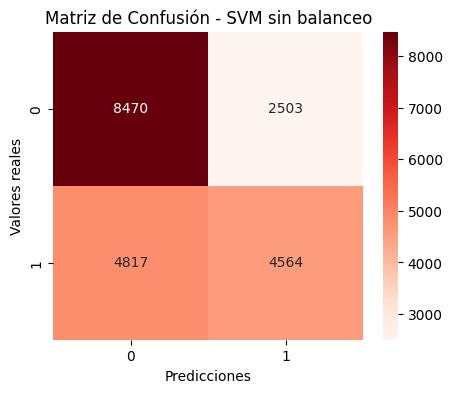

Modelo: SVM sin balanceo
Accuracy: 0.64
Precision: 0.646
Recall: 0.487
F1-score: 0.555
AUC: 0.692

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.64      0.77      0.70     10973
           1       0.65      0.49      0.55      9381

    accuracy                           0.64     20354
   macro avg       0.64      0.63      0.63     20354
weighted avg       0.64      0.64      0.63     20354



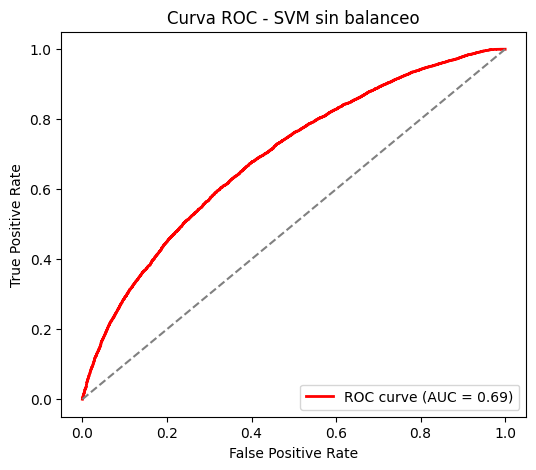

In [157]:
svm_normal = evaluar_modelo(svm_pipeline, X_test, y_test,nombre_modelo="SVM sin balanceo")

#### **Análisis de la Matriz de Confusión**

La matriz de confusión del **SVM sin técnica de balanceo** muestra un **desempeño superior en la identificación de la clase 0 (no reingresos)**, pero con un **rendimiento más limitado en la detección de reingresos (clase 1)**.  
Al no aplicar ningún método de balanceo, el modelo tiende a **favorecer la clase mayoritaria**, lo que se traduce en una sensibilidad más baja para los casos positivos.

- **Clase 0:** Se aciertan **8,470 observaciones (77%)** y se clasifican erróneamente **2,503 (23%)** como reingresos.  
- **Clase 1:** El modelo detecta correctamente **4,564 pacientes (49%)** que reingresan, mientras que **4,817 (51%)** son clasificados erróneamente como no reingresos.

En general, el modelo **prioriza la precisión sobre la sensibilidad**, lo que puede resultar en la **subdetección de pacientes con riesgo de reingreso**.

---

#### **Análisis de Métricas**

- **Accuracy (0.64):** El modelo logra un **64% de acierto global**, ligeramente superior a los modelos de Random Forest.  
- **Precision (0.646):** Aproximadamente **el 64.6% de las predicciones positivas son correctas**, lo que indica un nivel aceptable de confianza en las predicciones positivas.  
- **Recall (0.487):** El modelo **solo detecta al 48.7% de los pacientes que realmente reingresan**, lo cual refleja una **baja sensibilidad**.  
- **F1-score (0.555):** Representa un **equilibrio moderado entre precisión y recall**, aunque ligeramente inferior en balance comparado con modelos balanceados.  
- **AUC (0.692):** El área bajo la curva indica una **capacidad de discriminación moderada-alta**, superior a la mayoría de los modelos de Random Forest (AUC ≈ 0.67).

---

#### **Reporte de Clasificación**

| Clase | Precision | Recall | F1-score | Interpretación |
|:------|:----------:|:------:|:--------:|:--------------------------------------------------------------|
| **Clase 0 (No reingreso)** | 0.64 | 0.77 | 0.70 | Muestra una **alta precisión y sensibilidad** para los pacientes que no reingresan, reforzando el sesgo hacia la clase mayoritaria. |
| **Clase 1 (Reingreso)** | 0.65 | 0.49 | 0.55 | Aunque la precisión es aceptable, la **baja sensibilidad** indica que el modelo **no logra detectar la mitad de los reingresos reales**. |

---

#### **Curva ROC**

La **curva ROC** presenta un **AUC de 0.69**, lo que indica una **mejor capacidad discriminativa** respecto a los modelos de Random Forest (AUC ≈ 0.67).  
Esto sugiere que el SVM **diferencia de manera más clara ambas clases**, aunque todavía presenta dificultades para identificar todos los casos positivos.

---

#### **Conclusión General**

El **SVM sin técnica de balanceo** muestra un **buen desempeño global** con la **mayor exactitud (64%) y el AUC más alto (0.69)** entre los modelos evaluados hasta el momento.  
Sin embargo, su **baja sensibilidad (recall = 0.487)** refleja una **limitada capacidad para identificar pacientes que efectivamente reingresan**.

### **4.7.2 SVM con SMOTE**

In [158]:
svm_pipeline_smote = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("classifier", SVC(
        kernel="rbf",
        C=1.0,
        gamma="scale",
        probability=True,
        random_state=42
    ))
])

In [159]:
svm_pipeline_smote.fit(X_train, y_train)

c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\sklearnex\svm\_common.py:249: RuntimeWarning: random_state does not influence oneDAL SVM results
  warnings.warn(
c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['race', 'gender', 'age', 'admission...
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change'],
      dtype='object'))])),
                ('smote', SMOTE(random_state=42)),
                ('classifier', SVC(probability=True, random_state=42))])

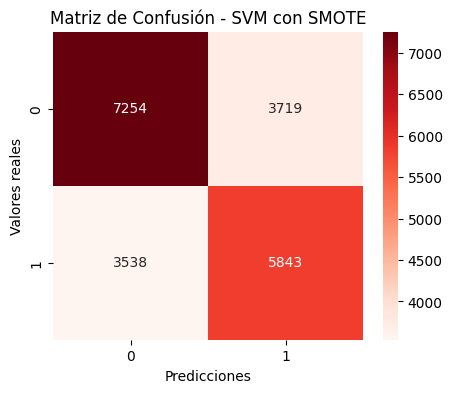

Modelo: SVM con SMOTE
Accuracy: 0.643
Precision: 0.611
Recall: 0.623
F1-score: 0.617
AUC: 0.693

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.67      0.66      0.67     10973
           1       0.61      0.62      0.62      9381

    accuracy                           0.64     20354
   macro avg       0.64      0.64      0.64     20354
weighted avg       0.64      0.64      0.64     20354



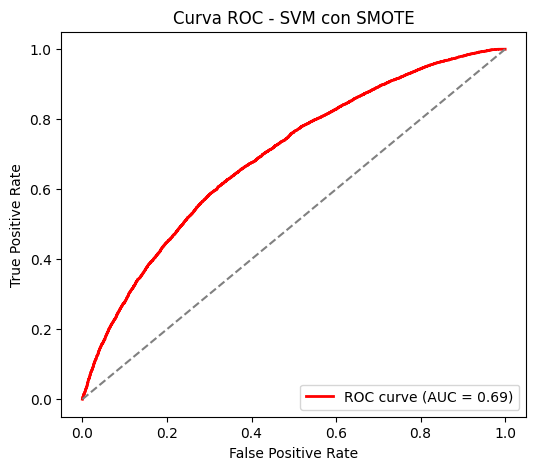

In [160]:
svm_smote = evaluar_modelo(svm_pipeline_smote, X_test, y_test, nombre_modelo="SVM con SMOTE")

#### **Análisis de la Matriz de Confusión**

La matriz de confusión del **SVM con técnica de balanceo SMOTE** evidencia una **mejor distribución de aciertos entre ambas clases**, reflejando el impacto positivo del sobremuestreo.  
El uso de **SMOTE (Synthetic Minority Over-sampling Technique)** permite generar instancias sintéticas de la clase minoritaria, reduciendo el sesgo hacia la clase mayoritaria.

- **Clase 0:** Se aciertan **7,254 observaciones (66%)** y se clasifican erróneamente **3,719 (34%)** como reingresos.  
- **Clase 1:** El modelo detecta correctamente **5,843 pacientes (62%)** que reingresan, mientras que **3,538 (38%)** son clasificados erróneamente como no reingresos.

Este resultado muestra que el modelo **logra equilibrar la detección entre ambas clases**, mejorando significativamente la sensibilidad hacia los reingresos en comparación con el SVM sin balanceo.

---

#### **Análisis de Métricas**

- **Accuracy (0.643):** El modelo alcanza un **64.3% de acierto global**, manteniendo un rendimiento muy similar al SVM sin balanceo (0.64).  
- **Precision (0.611):** Aproximadamente **el 61% de las predicciones positivas son correctas**, lo que indica una precisión estable.  
- **Recall (0.623):** Se observa una **mejor sensibilidad (62%)**, superando ampliamente el **48.7%** del modelo sin balanceo, lo cual evidencia el efecto positivo del SMOTE.  
- **F1-score (0.617):** Representa un **buen equilibrio entre precisión y recall**, siendo una de las puntuaciones más altas entre todos los modelos probados.  
- **AUC (0.693):** Indica una **capacidad discriminativa moderada-alta**, ligeramente superior a la del SVM sin balanceo (AUC = 0.692).

---

#### **Reporte de Clasificación**

| Clase | Precision | Recall | F1-score | Interpretación |
|:------|:----------:|:------:|:--------:|:--------------------------------------------------------------|
| **Clase 0 (No reingreso)** | 0.67 | 0.66 | 0.67 | Mantiene un desempeño consistente en la clasificación de pacientes que no reingresan, con una ligera reducción de precisión para ganar sensibilidad. |
| **Clase 1 (Reingreso)** | 0.61 | 0.62 | 0.62 | Presenta una **mejora clara en la detección de reingresos**, alcanzando un equilibrio entre precisión y sensibilidad gracias a SMOTE. |

---

#### **Curva ROC**

La **curva ROC** con un **AUC de 0.693** muestra una **buena capacidad del modelo para distinguir entre pacientes que reingresan y los que no**.  
Este valor es **ligeramente superior** al obtenido por el SVM sin balanceo, lo que confirma que **SMOTE no solo mejora el recall, sino también la discriminación general del modelo**.

---

#### **Conclusión General**

El **SVM con SMOTE** logra un **rendimiento más equilibrado entre ambas clases**, mostrando **mejor recall (62%) y F1-score (0.617)** que el modelo sin balanceo, sin sacrificar la precisión ni el AUC.  
Esto demuestra que **la aplicación de SMOTE mejora la detección de reingresos hospitalarios**, haciendo al modelo **más justo**.


### **4.7.3 SVM con ADASYN**

In [161]:

svm_pipeline_adasyn = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("adasyn", ADASYN(random_state=42)),
    ("classifier", SVC(
        kernel="rbf",
        C=1.0,
        gamma="scale",
        probability=True,
        random_state=42
    ))
])


try:
    svm_pipeline_adasyn.fit(X_train, y_train)
    svm_adasyn = evaluar_modelo(svm_pipeline_adasyn, X_test, y_test, nombre_modelo="SVM con ADASYN")
except ValueError as e:
    print(f"ADASYN no pudo generar muestras sintéticas: {e}")
    svm_adasyn = {"Modelo": "SVM con ADASYN", "Accuracy": None, "Precision": None, "Recall": None, "F1": None, "AUC": None}

c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


ADASYN no pudo generar muestras sintéticas: No samples will be generated with the provided ratio settings.


Gracias al balanceo existente en la clase objetivo, como se puede ver a continuacion, ADASYN no puede crear datos sinteticos para poder balancear, en este caso, no se tomara en cuenta.

In [162]:
y_train.value_counts(normalize=True)

readmitted
0    0.539122
1    0.460878
Name: proportion, dtype: float64

### **4.7.4 SVM con class_weight=’balanced’**


In [163]:
svm_pipeline_balanced = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", SVC(
        kernel="rbf",
        C=1.0,
        gamma="scale",
        probability=True,
        class_weight="balanced",
        random_state=42
    ))
])


In [164]:
svm_pipeline_balanced.fit(X_train, y_train)

c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\sklearnex\svm\_common.py:249: RuntimeWarning: random_state does not influence oneDAL SVM results
  warnings.warn(
c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['race', 'gender', 'age', 'admission...
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change'],
      dtype='object'))])),
                ('classifier',
                 SVC(class_weight='balanced', probability=True,
                     random_state=42))])

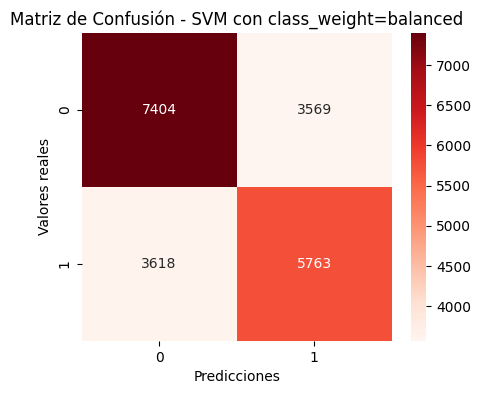

Modelo: SVM con class_weight=balanced
Accuracy: 0.647
Precision: 0.618
Recall: 0.614
F1-score: 0.616
AUC: 0.694

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.67      0.67      0.67     10973
           1       0.62      0.61      0.62      9381

    accuracy                           0.65     20354
   macro avg       0.64      0.64      0.64     20354
weighted avg       0.65      0.65      0.65     20354



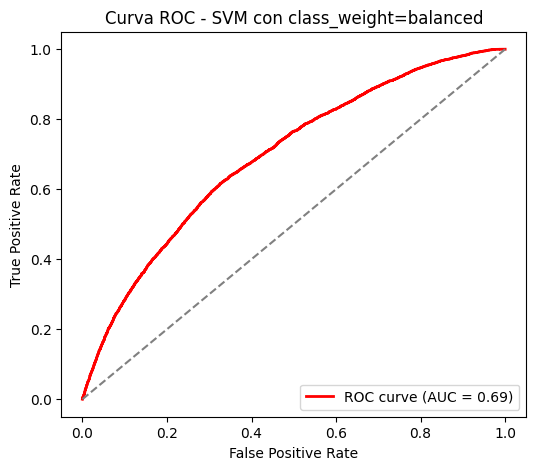

In [165]:
svm_balanced = evaluar_modelo(svm_pipeline_balanced, X_test, y_test, nombre_modelo="SVM con class_weight=balanced")

#### **Análisis de la Matriz de Confusión**

La matriz de confusión del **SVM con `class_weight = balanced`** muestra un desempeño **más equitativo entre ambas clases**, gracias a la asignación automática de pesos inversamente proporcionales a la frecuencia de cada clase.  
Este enfoque busca **penalizar más los errores en la clase minoritaria** (reingresos), equilibrando el proceso de aprendizaje sin necesidad de generar datos sintéticos como en SMOTE.

- **Clase 0:** Se aciertan **7,404 observaciones (67%)** y se clasifican erróneamente **3,569 (33%)** como reingresos.  
- **Clase 1:** El modelo detecta correctamente **5,763 pacientes (61%)** que reingresan, mientras que **3,618 (39%)** son clasificados erróneamente como no reingresos.  

Este comportamiento evidencia una **mejor distribución de aciertos entre las dos clases**, similar al modelo con SMOTE, pero alcanzado mediante un ajuste de pesos y no mediante modificación del conjunto de datos.

---

#### **Análisis de Métricas**

- **Accuracy (0.647):** El modelo logra un **64.7% de acierto global**, ligeramente superior al obtenido con SMOTE (0.643).  
- **Precision (0.618):** Cerca del **62% de las predicciones positivas son correctas**, mostrando una precisión estable y equilibrada.  
- **Recall (0.614):** Se alcanza una **sensibilidad del 61%**, lo que refleja una **mejor capacidad de detección de pacientes que reingresan** sin sacrificar demasiada precisión.  
- **F1-score (0.616):** Muestra un **equilibrio sólido entre precisión y recall**, prácticamente idéntico al SVM con SMOTE (0.617).  
- **AUC (0.694):** El área bajo la curva ROC confirma una **capacidad de discriminación moderadamente alta**, ligeramente superior a la de las configuraciones previas.

---

#### **Reporte de Clasificación**

| Clase | Precision | Recall | F1-score | Interpretación |
|:------|:----------:|:------:|:--------:|:--------------------------------------------------------------|
| **Clase 0 (No reingreso)** | 0.67 | 0.67 | 0.67 | Mantiene un desempeño equilibrado en la correcta identificación de pacientes que no reingresan. |
| **Clase 1 (Reingreso)** | 0.62 | 0.61 | 0.62 | Logra una **detección estable y consistente de la clase minoritaria**, sin sobreajustar ni perder generalización. |

---

#### **Curva ROC**

La **curva ROC** con un **AUC de 0.694** indica una **ligeramente mejor capacidad de discriminación** que los modelos anteriores (SVM sin balanceo y SVM con SMOTE).  
Esto sugiere que el **ajuste de pesos internos del modelo** es suficiente para **balancear el rendimiento sin necesidad de aplicar técnicas de sobremuestreo**.

---

#### **Conclusión General**

El **SVM con `class_weight=balanced`** presenta el **mejor rendimiento global** dentro de las variantes del modelo SVM, destacando por su:
- **Mejor exactitud (0.647)**  
- **AUC ligeramente superior (0.694)**  
- **Excelente equilibrio entre precisión (0.618) y recall (0.614)**  

Comparado con el SVM sin balanceo, este modelo **incrementa notablemente la sensibilidad (de 0.487 a 0.614)**, reduciendo el sesgo hacia la clase mayoritaria. Y frente al SVM con SMOTE, logra **resultados prácticamente equivalentes**, con la ventaja de **mantener los datos originales** y evitar el aumento artificial del conjunto de entrenamiento.

### **4.7.5 Comparacion de resultados de tecnicas de balanceo para SVM**


In [166]:
tabla_resultados = pd.DataFrame([
    svm_normal,
    svm_smote,
    svm_balanced
])

In [167]:
# Ordenar por Recall descendente
df_ordenado = tabla_resultados.sort_values(by="Recall", ascending=False).reset_index(drop=True)

# Mostrar tabla ordenada
display(df_ordenado.sort_values(by="Recall", ascending=False))

,Modelo,Accuracy,Precision,Recall,F1,AUC
0,SVM con SMOTE,0.643461,0.611065,0.622855,0.616903,0.692940
1,SVM con class_weight=balanced,0.646900,0.617553,0.614327,0.615935,0.694235
2,SVM sin balanceo,0.640366,0.645819,0.486515,0.554961,0.691903


#### **Conclusión General – Modelos SVM**

Los resultados obtenidos para los tres enfoques del **Support Vector Machine (SVM)** permiten observar diferencias relevantes en el equilibrio entre precisión, sensibilidad y capacidad de discriminación.  

---

#### **Análisis Comparativo**

- El **SVM sin balanceo** presenta una **alta precisión (0.646)**, pero con una **sensibilidad muy baja (0.487)**, lo que evidencia un sesgo hacia la clase mayoritaria. Es decir, identifica bien los “no reingresos” pero **omite muchos casos positivos** (pacientes que sí reingresan).  
- El **SVM con SMOTE** mejora significativamente el **recall (0.623)**, logrando una **mayor detección de reingresos**, aunque con una ligera reducción en precisión. Su F1-score (0.617) y AUC (0.693) reflejan un **modelo más equilibrado y con mejor discriminación**.  
- El **SVM con `class_weight=balanced`** obtiene los **mejores resultados globales**, con **mayor exactitud (0.647)** y el **AUC más alto (0.694)**. Este modelo mantiene un **equilibrio sólido entre precisión y recall**, sin necesidad de modificar el conjunto de datos mediante técnicas de sobremuestreo.

---

#### **Selección del Mejor Modelo**

El **SVM con `class_weight=balanced`** es el **modelo más robusto y balanceado** de los tres.  
Ofrece:
- Un rendimiento global más alto (**Accuracy = 0.647**).  
- Una **capacidad discriminativa superior (AUC = 0.694)**.  
- Un **equilibrio adecuado entre precisión y sensibilidad**, garantizando una detección efectiva de pacientes en riesgo de reingreso sin aumentar excesivamente los falsos positivos.


## **4.8 Comparacion de mejores modelos seleccionados usando tecnicas de balanceo**

In [168]:
tabla_resultados = pd.DataFrame([
    result_sin,
    result_con,
    result_weights,
    bayes_sin,
    bayes_con,
    result_l1,
    result_l2,
    result_weights_l1,
    result_weights_l2,
    result_l1_bal,
    result_l2_bal,
    arbol_sin,
    arbol_con,
    arbol_classweight,
    rf_normal,
    rf_smote,
    rf_balanced,
    xgb_normal,
    xgb_smote,
    xgb_balanced,
    svm_normal,
    svm_smote,
    svm_balanced
])

In [ ]:
df_ordenado = tabla_resultados.sort_values(by="Recall", ascending=False).reset_index(drop=True)
display(df_ordenado.sort_values(by="Recall", ascending=False))


,Modelo,Accuracy,Precision,Recall,F1,AUC
0,Clasificador Bayesiano sin balanceo,0.493367,0.475967,0.982731,0.641322,0.642233
1,Clasificador Bayesiano con SMOTE,0.494252,0.476348,0.980066,0.641099,0.641488
2,RandomForest con class_weight=balanced,0.623514,0.585746,0.625520,0.604980,0.677233
3,SVM con SMOTE,0.643461,0.611065,0.622855,0.616903,0.692940
4,SVM con class_weight=balanced,0.646900,0.617553,0.614327,0.615935,0.694235
5,XGBoost con scale_pos_weight,0.640709,0.610023,0.611129,0.610576,0.694900
6,Regresion logistica (L2) con SMOTE,0.626265,0.596162,0.586185,0.591131,0.680056
7,Regresión L2 class_weight=balanced,0.629213,0.601618,0.578723,0.589948,0.681131
8,Regresión L1 class_weight=balanced,0.628722,0.601131,0.577870,0.589271,0.681187
9,KNN con SMOTE,0.570944,0.533375,0.551967,0.542511,0.602022
